# Explore differential expression analysis results

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time


sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [3]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

## Read best DE results, filter based on number of DE genes and on-target KD effects

In [18]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [19]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

In [8]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [45]:
# Perturbation selection
mask = (de_summary_stats.n_total_de_genes>30) & (de_summary_stats.n_cells_target>75)# & (de_summary_stats.ontarget_effect_category=='on-target KD')
obs_names_mask = de_summary_stats[mask].obs_names
adata_de_filtered = adata_de[adata_de.obs_names.isin(obs_names_mask)].copy()
adata_de_filtered.var_names = adata_de_filtered.var.gene_name
adata_de_filtered.X = np.nan_to_num(adata_de_filtered.layers['zscore'], 0).copy()

In [46]:
# Mask the on-target zscore
for obs_name in adata_de_filtered.obs_names:
    gene_id = adata_de_filtered[obs_name].obs['target_contrast'].values[0]
    adata_de_filtered[obs_name, adata_de_filtered.var['gene_ids']==gene_id].X=0
adata_de_filtered.layers['masked_zscore'] = adata_de_filtered.X.copy()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_83289/387600065.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_de_filtered[obs_name, adata_de_filtered.var['gene_ids']==gene_id].X=0


In [48]:
# Select features with variance in the top 50% and/or top 200 differentially expressed genes for all perturbations ordered by zscores that are significant
zscore = adata_de_filtered.layers['zscore']
padj = adata_de_filtered.layers['adj_p_value']
zscore = zscore*(padj<0.1)
zscore_ranking = np.argsort(zscore, axis=1)
top100_mask = np.sum(((zscore_ranking>(np.max(zscore_ranking)-100))*(zscore>0))|((zscore_ranking<100)*(zscore<0)), axis=0)>0
var_mask = adata_de_filtered.X.var(axis=0)>np.percentile(adata_de_filtered.X.var(axis=0), 50)
adata_de_filtered = adata_de_filtered[:,top100_mask|var_mask].copy()

In [10]:
adata_de_filtered

AnnData object with n_obs × n_vars = 4621 × 7521
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore', 'masked_zscore'

In [11]:
adata_de_filtered.write_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')

In [51]:
adata_cluster = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')

### Simple PCA clustering

In [ ]:
sc.pp.scale(adata_cluster)

In [ ]:
sc.pp.pca(adata_cluster, n_comps=300)

In [ ]:
sc.pl.pca_variance_ratio(adata_cluster, n_pcs=150, log=True)

In [ ]:
variance_ratio = adata_cluster.uns['pca']['variance_ratio']
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')

In [3]:
adata_cluster = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')

In [4]:
def generate_masks(data_length: int, percentage: float, num_times: int, random_seed=42) -> List[List[bool]]:
    np.random.seed(random_seed)
    sample_size = int(data_length * (percentage / 100.0))
    masks = []
    for _ in range(num_times):
        indices = np.random.choice(data_length, size=sample_size, replace=False)
        mask = np.zeros(data_length, dtype=bool)
        mask[indices] = True
        masks.append(mask)
    return masks


def running_clustering(obs_mask, var_mask, n_comp_all=[50,100,150], n_neighbor_all=[7,15,31,63,127], resolution_all=[1.5,2,3,4]):
    warnings.filterwarnings('ignore')
    """
    Running leiden clustering with parameter grid
    """
    N = len(adata_cluster)
    # Subsetting the adata
    adata_tmp = adata_cluster[obs_mask, var_mask].copy()
    # Perform PCA
    sc.pp.scale(adata_tmp)
    sc.pp.pca(adata_tmp, n_comps=max(n_comp_all))
    clustering_batch = []
    for n_comp in n_comp_all:
        for n_neighbor in n_neighbor_all:
            # Perform knn
            sc.pp.neighbors(adata_tmp, n_pcs=n_comp, n_neighbors=n_neighbor, random_state=42)
            for resolution in resolution_all:
                # Perform leiden
                sc.tl.leiden(adata_tmp, resolution=resolution, random_state=42)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype(int)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype('category')
                cluster_labels_numerical = adata_tmp.obs['leiden'].cat.codes
                clustering_tmp = np.full(N, np.nan)
                clustering_tmp[obs_mask] = cluster_labels_numerical
                clustering_batch.append({'n_comp':n_comp,
                                         'n_neighbor':n_neighbor,
                                         'resolution':resolution,
                                         'leiden_assignment': clustering_tmp,
                                         'obs_mask': obs_mask,
                                         'var_mask': var_mask})
    return clustering_batch

In [5]:
N = adata_cluster.shape[0]
M = adata_cluster.shape[1]
num_of_repeat = 150
obs_perc = 70
var_perc = 70
obs_mask_full = [np.full(N, True)] * num_of_repeat
obs_mask_bs = generate_masks(N, obs_perc, num_of_repeat, 42)
var_mask_full = [np.full(M, True)] * num_of_repeat
var_mask_bs = generate_masks(M, var_perc, num_of_repeat, 7)
mask_all = pd.DataFrame({'obs_mask': obs_mask_full+obs_mask_bs,
                         'var_mask': var_mask_bs+var_mask_full})

In [ ]:
start_time = time.time()
def run_one_clustering(row):
    warnings.filterwarnings('ignore')
    return running_clustering(row.obs_mask, row.var_mask)

# Run in parallel
clustering_all = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one_clustering)(row) for _, row in tqdm(mask_all.iterrows(), total=len(mask_all))
)

clustering_all = [item for sublist in clustering_all for item in sublist]
end_time = time.time()
print(end_time-start_time)

In [7]:
clustering_summary = pd.DataFrame(clustering_all)
#clustering_summary.to_parquet('results/pca_params_screening_de30ntotal75_varfiltered.parquet')
clustering_summary.to_parquet('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_varfiltered_neighbor7127resolution14.parquet')

In [3]:
clustering_summary = pd.read_parquet('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_varfiltered_neighbor7127resolution14.parquet')

### Build consensus matrix

In [8]:
# Summing all clustering results
n_cells = len(clustering_summary.loc[0, 'leiden_assignment'])
condensed_cooc_matrix_all = np.zeros(n_cells*n_cells)
for i in range(len(clustering_summary)):
    if i % 500 == 0:
        print(i)
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_summary.loc[i, 'leiden_assignment']
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all = condensed_cooc_matrix_all + cooc_matrix.flatten()

# Normalize the consensus matrix
norm_cooc_matrix = condensed_cooc_matrix_all.reshape([n_cells, n_cells])/len(clustering_summary)
distance_matrix = 1 - norm_cooc_matrix
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix)

adata_cluster = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')
list1 = adata_cluster.obs.target_contrast_gene_name_corrected.values
list2 = adata_cluster.obs.culture_condition.values
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
norm_cooc_matrix_df = pd.DataFrame(data=norm_cooc_matrix,
                                   index=ind,
                                   columns=ind)

norm_cooc_matrix_df.to_csv('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_varfiltered_neighbor7127resolution14_cooc_matrix.csv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500


In [ ]:
# # Quick check of consensus matrix
# clustermap = sns.clustermap(
#     cooc_corr_matrix,
#     method='ward', metric='euclidean',
#     figsize=(8,8), 
#     cmap='vlag'
# )

<Axes: >

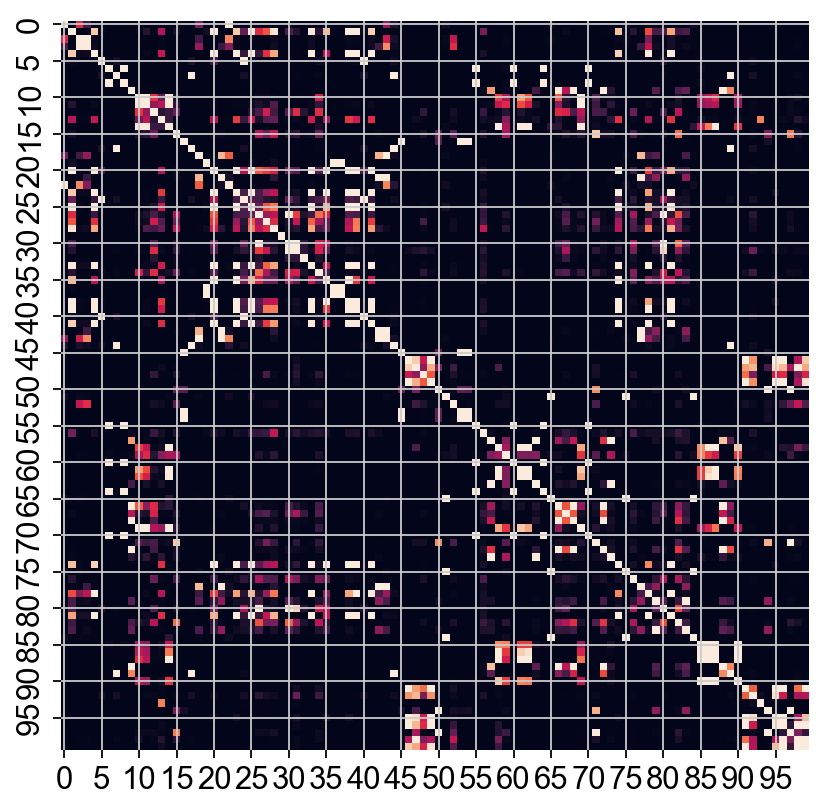

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(norm_cooc_matrix[:100,:100], vmin=0, vmax=0.3, ax=ax, cbar=False)

In [10]:
adata_cluster = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')
norm_cooc_matrix_df = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_varfiltered_neighbor7127resolution14_cooc_matrix.csv', index_col=0)
distance_matrix_df = 1 - norm_cooc_matrix_df
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix_df.values)
np.fill_diagonal(distance_matrix_df.values, 1)

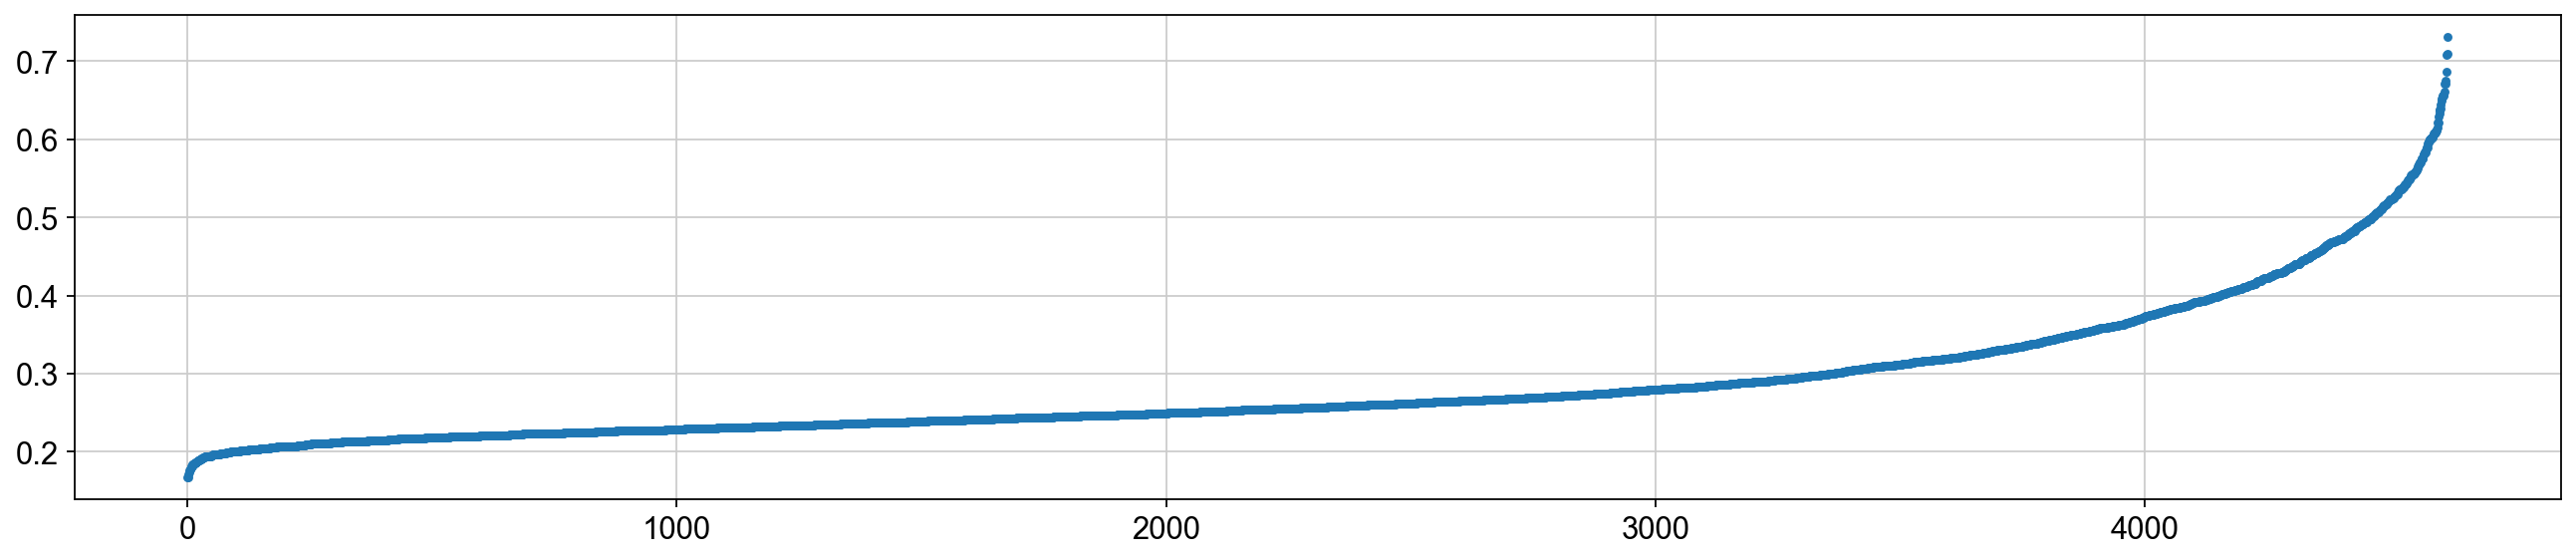

In [159]:
plt.plot(np.sort(distance_matrix_df.min(0)), '.')

In [160]:
# Filter if a perturbation is too far away from other perturbations
distance_matrix_df = distance_matrix_df.loc[distance_matrix_df.min(0)<0.35, distance_matrix_df.min(1)<0.35].copy()
adata_cluster.obs_names = [item1+'_'+item2 for item1, item2 in zip(adata_cluster.obs['target_contrast_gene_name_corrected'], adata_cluster.obs['culture_condition'])]
adata_cluster = adata_cluster[distance_matrix_df.index].copy()

In [163]:
# Run hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=3,
                            min_samples=1,
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix_df.values)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')
adata_cluster = adata_cluster[adata_cluster.obs['hdbscan']!=-1].copy()

In [164]:
adata_cluster.obs.hdbscan.unique()

[94, 39, 40, 105, 12, ..., 60, 133, 79, 62, 91]
Length: 154
Categories (154, int64): [0, 1, 2, 3, ..., 150, 151, 152, 153]

In [165]:
# For each cluster, filter out perturbations that have low correlation with other genes
filter_thres = 0.2
perturbation_to_include = []
for cl in adata_cluster.obs['hdbscan'].unique():
    df = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==cl].layers['zscore'],
                      index=adata_cluster[adata_cluster.obs['hdbscan']==cl].obs_names,
                      columns=adata_cluster.var_names)
    df_corr = df.T.corr()
    np.fill_diagonal(df_corr.values, 0)
    perturbation_to_include = perturbation_to_include + df_corr.loc[df_corr.mean(0)>filter_thres].index.tolist()

adata_cluster = adata_cluster[perturbation_to_include].copy()
distance_matrix_df = distance_matrix_df.loc[perturbation_to_include, perturbation_to_include].copy()

# Rerun hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=3,
                            min_samples=1, 
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix_df.values)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')
adata_cluster = adata_cluster[adata_cluster.obs['hdbscan']!=-1].copy()

In [166]:
adata_cluster

AnnData object with n_obs × n_vars = 2462 × 7521
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [17]:
Tcellsignal = ['CD3D','ZAP70','LAT','FYN','ITAM','ITK','GADS','ADAP','GRB2','PLCG1','PLCG2','WAS','RAC2','CD28','DEF6','CD2']

In [38]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected=='TSC1'].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000165699_Rest                      TSC1              Rest   

                      target_contrast chunk  n_cells_target  \
ENSG00000165699_Rest  ENSG00000165699   325           492.0   

                     target_contrast_corrected  \
ENSG00000165699_Rest           ENSG00000165699   

                     target_contrast_gene_name_corrected hdbscan  
ENSG00000165699_Rest                                TSC1      52

In [19]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected=='MED19'].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
MED19_Rest                         MED19              Rest  ENSG00000156603   
MED19_Stim8hr                      MED19           Stim8hr  ENSG00000156603   
MED19_Stim48hr                     MED19          Stim48hr  ENSG00000156603   

               chunk  n_cells_target target_contrast_corrected  \
MED19_Rest         6           877.0           ENSG00000156603   
MED19_Stim8hr    129           977.0           ENSG00000156603   
MED19_Stim48hr   338           660.0           ENSG00000156603   

               target_contrast_gene_name_corrected hdbscan  
MED19_Rest                                   MED19       6  
MED19_Stim8hr                                MED19       6  
MED19_Stim48hr                               MED19       7

In [20]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.isin(Tcellsignal)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
CD2_Stim8hr                          CD2           Stim8hr  ENSG00000116824   
CD2_Stim48hr                         CD2          Stim48hr  ENSG00000116824   
CD28_Stim48hr                       CD28          Stim48hr  ENSG00000178562   
CD28_Stim8hr                        CD28           Stim8hr  ENSG00000178562   
CD3D_Stim48hr                       CD3D          Stim48hr  ENSG00000167286   
CD3D_Stim8hr                        CD3D           Stim8hr  ENSG00000167286   
DEF6_Stim8hr                        DEF6           Stim8hr  ENSG00000023892   
ITK_Stim48hr                         ITK          Stim48hr  ENSG00000113263   
ITK_Stim8hr                          ITK           Stim8hr  ENSG00000113263   
LAT_Stim48hr                         LAT          Stim48hr  ENSG00000213658   
LAT_Stim8hr                          LAT           Stim8hr  ENSG00000213658   
PLCG1_Stim48hr                     PLCG1          Stim48hr  ENSG00000124181   
PLCG1_Stim8hr                      PLCG1           Stim8hr  ENSG00000124181   
RAC2_Rest                           RAC2              Rest  ENSG00000128340   
RAC2_Stim48hr                       RAC2          Stim48hr  ENSG00000128340   
RAC2_Stim8hr                        RAC2           Stim8hr  ENSG00000128340   
WAS_Stim8hr                          WAS           Stim8hr  ENSG00000015285   
ZAP70_Rest                         ZAP70              Rest  ENSG00000115085   
ZAP70_Stim8hr                      ZAP70           Stim8hr  ENSG00000115085   

               chunk  n_cells_target target_contrast_corrected  \
CD2_Stim8hr      675           378.0           ENSG00000116824   
CD2_Stim48hr      64           478.0           ENSG00000116824   
CD28_Stim48hr    401           514.0           ENSG00000178562   
CD28_Stim8hr      99           675.0           ENSG00000178562   
CD3D_Stim48hr    634            85.0           ENSG00000167286   
CD3D_Stim8hr     436           185.0           ENSG00000167286   
DEF6_Stim8hr     447           541.0           ENSG00000023892   
ITK_Stim48hr     610           361.0           ENSG00000113263   
ITK_Stim8hr      443           517.0           ENSG00000113263   
LAT_Stim48hr     635           295.0           ENSG00000213658   
LAT_Stim8hr      662           469.0           ENSG00000213658   
PLCG1_Stim48hr   210           267.0           ENSG00000124181   
PLCG1_Stim8hr     87           421.0           ENSG00000124181   
RAC2_Rest        357           524.0           ENSG00000128340   
RAC2_Stim48hr    392           519.0           ENSG00000128340   
RAC2_Stim8hr      46           576.0           ENSG00000128340   
WAS_Stim8hr      164           522.0           ENSG00000015285   
ZAP70_Rest       397           141.0           ENSG00000115085   
ZAP70_Stim8hr    249           144.0           ENSG00000115085   

               target_contrast_gene_name_corrected hdbscan  
CD2_Stim8hr                                    CD2      37  
CD2_Stim48hr                                   CD2     109  
CD28_Stim48hr                                 CD28     109  
CD28_Stim8hr                                  CD28      37  
CD3D_Stim48hr                                 CD3D     109  
CD3D_Stim8hr                                  CD3D      37  
DEF6_Stim8hr                                  DEF6      37  
ITK_Stim48hr                                   ITK     109  
ITK_Stim8hr                                    ITK      37  
LAT_Stim48hr                                   LAT     109  
LAT_Stim8hr                                    LAT      37  
PLCG1_Stim48hr                               PLCG1     109  
PLCG1_Stim8hr                                PLCG1      37  
RAC2_Rest                                     RAC2      73  
RAC2_Stim48hr                                 RAC2     109  
RAC2_Stim8hr                                  RAC2      37  
WAS_Stim8hr                                    WAS      37  
ZAP70_Rest     

In [21]:
adata_cluster[adata_cluster.obs.hdbscan==43].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
DNAJC24_Stim8hr                   DNAJC24           Stim8hr  ENSG00000170946   
DPH1_Stim8hr                         DPH1           Stim8hr  ENSG00000108963   
DPH5_Stim8hr                         DPH5           Stim8hr  ENSG00000117543   
DPH6_Stim8hr                         DPH6           Stim8hr  ENSG00000134146   
TPT1_Stim8hr                         TPT1           Stim8hr  ENSG00000133112   
TTC4_Stim8hr                         TTC4           Stim8hr  ENSG00000243725   

                chunk  n_cells_target target_contrast_corrected  \
DNAJC24_Stim8hr   263           429.0           ENSG00000170946   
DPH1_Stim8hr      550           233.0           ENSG00000108963   
DPH5_Stim8hr      636           289.0           ENSG00000117543   
DPH6_Stim8hr      130           327.0           ENSG00000134146   
TPT1_Stim8hr      286           191.0           ENSG00000133112   
TTC4_Stim8hr      331           102.0           ENSG00000243725   

                target_contrast_gene_name_corrected hdbscan  
DNAJC24_Stim8hr                             DNAJC24      43  
DPH1_Stim8hr                                   DPH1      43  
DPH5_Stim8hr                                   DPH5      43  
DPH6_Stim8hr                                   DPH6      43  
TPT1_Stim8hr                                   TPT1      43  
TTC4_Stim8hr                                   TTC4      43

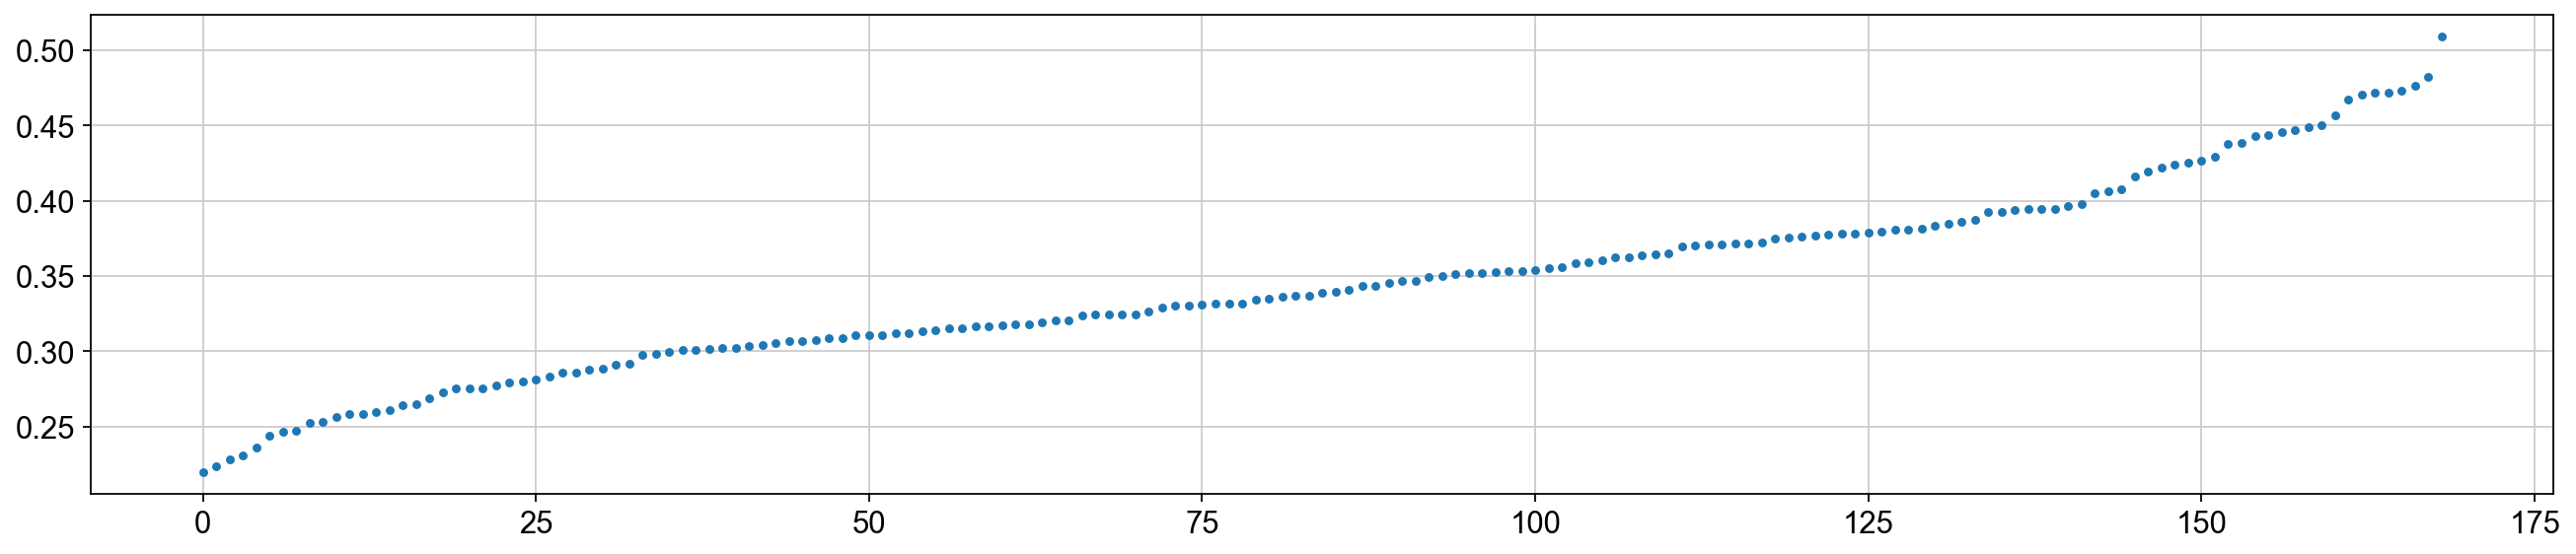

In [22]:
i = 109
df = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==i].layers['zscore'],
                    index=adata_cluster[adata_cluster.obs['hdbscan']==i].obs_names,
                    columns=adata_cluster.var_names)
df_corr = df.T.corr()
np.fill_diagonal(df_corr.values, 0)
plt.plot(np.sort(df_corr.mean(0)), '.')

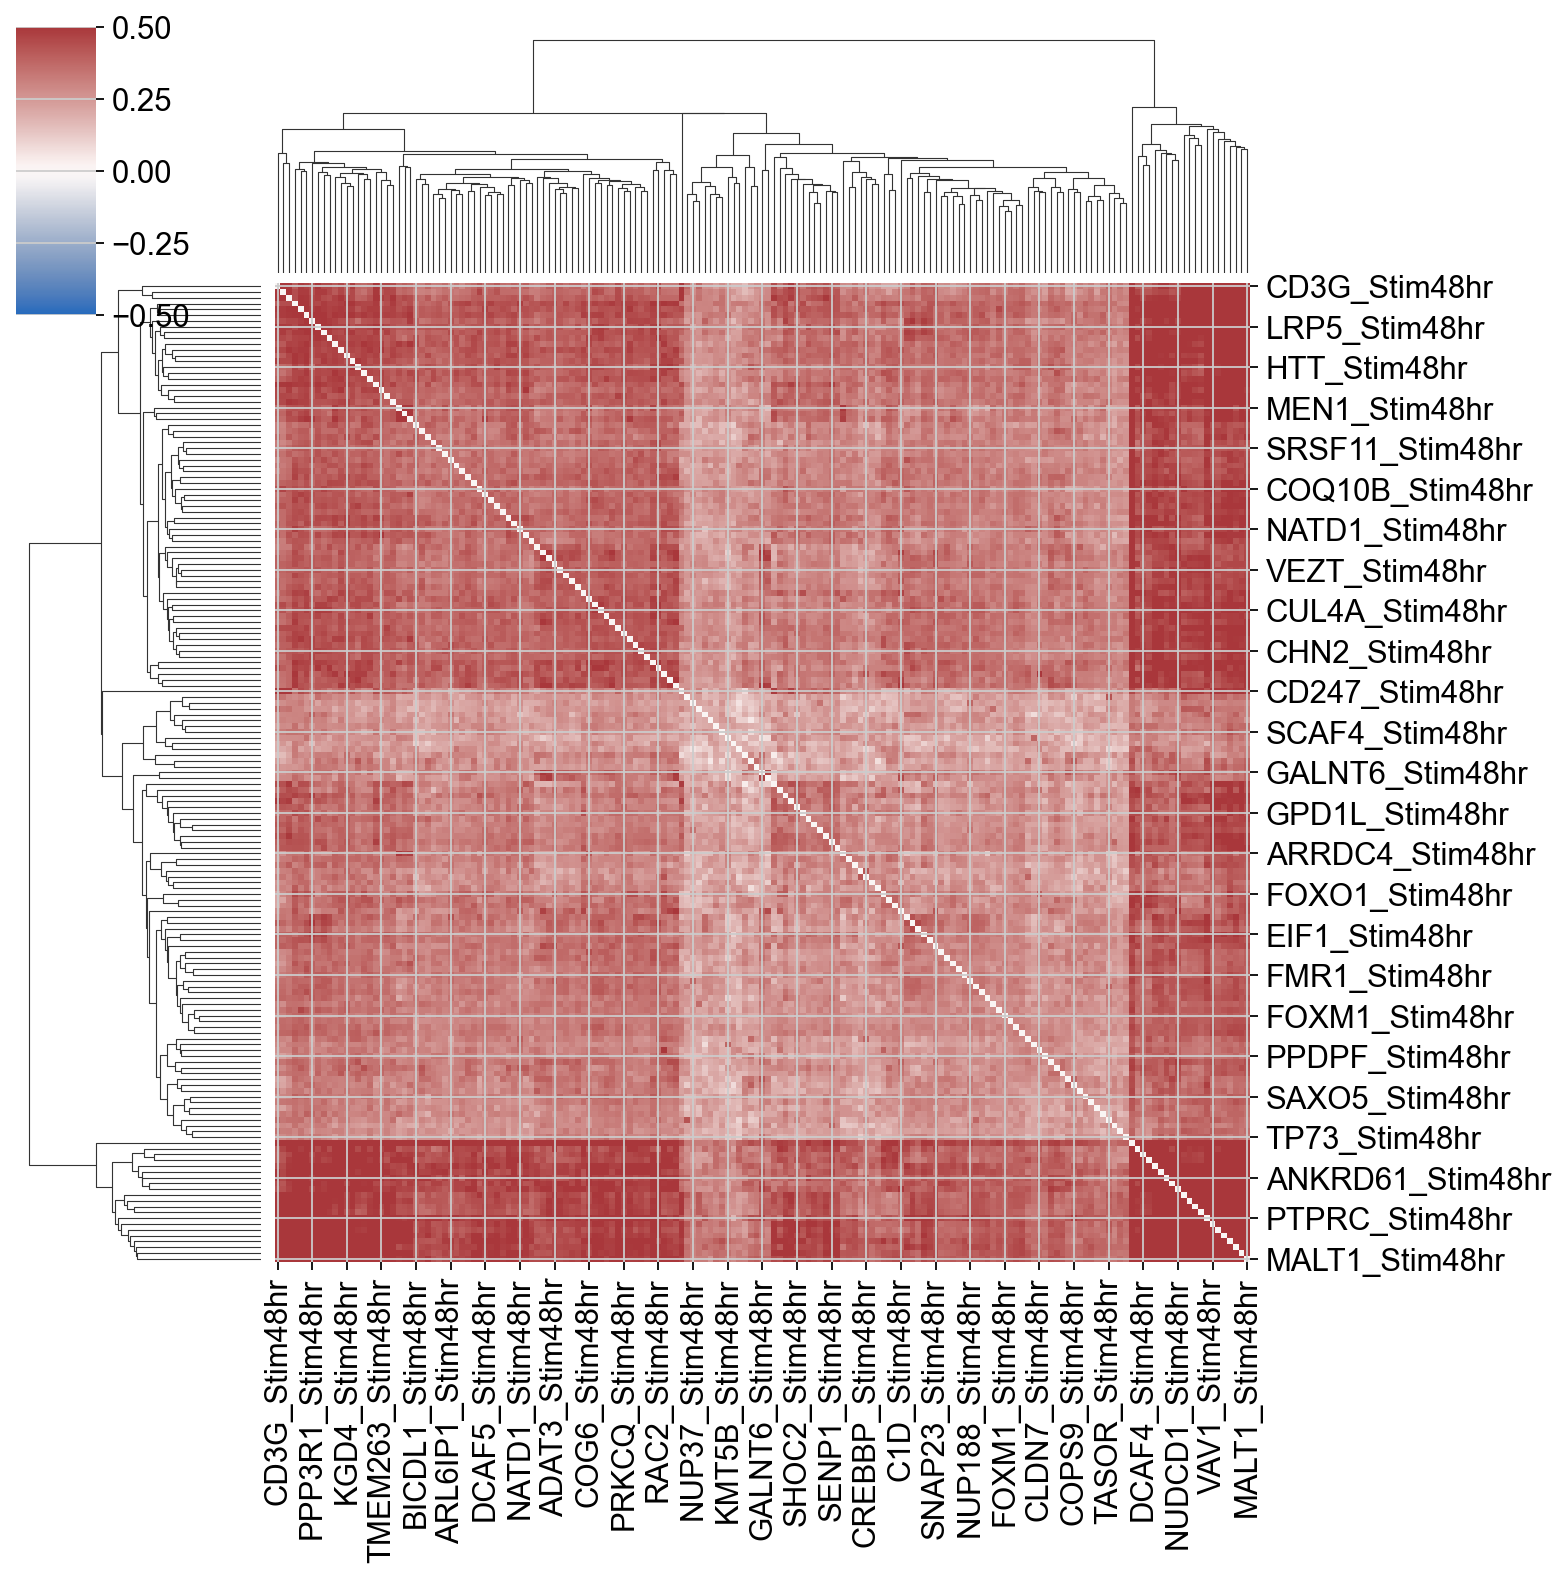

In [23]:
sns.clustermap(df_corr, vmin=-0.5, vmax=0.5, cmap='vlag')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
cluster_label = 'hdbscan'
j = 56
data = adata_cluster[adata_cluster.obs[cluster_label]==j].layers['zscore']
list1 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.target_contrast_gene_name_corrected.values.tolist()
list2 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.culture_condition.values.tolist()
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
for i in range(75,80):
    data = np.concatenate([data, adata_cluster[adata_cluster.obs[cluster_label]==i+1].layers['zscore']])
    list1 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.target_contrast_gene_name.values.tolist()
    list2 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
test = pd.DataFrame(data=data,
                    index=ind,
                    columns=adata_cluster.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, vmin=-0.5, vmax=0.5, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax)
plt.tight_layout()

### Filter out low quality hdbscan clusters

In [167]:
np.max(adata_cluster.obs['hdbscan'].astype(int))

109

In [168]:
# Calculate cluster metrics, add to annotation
adata_cluster.obs['hdbscan_cluster_size'] = 0
adata_cluster.obs['hdbscan_cluster_gene_size'] = 0
num_of_cluster = len(adata_cluster.obs['hdbscan'].unique())
cluster_num = []
corr = []
cluster_size = []
cluster_gene_size = []
cluster_member = []
for i, cl in enumerate(adata_cluster.obs['hdbscan'].unique()):
    df = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==cl].layers['zscore'],
                        index=adata_cluster[adata_cluster.obs['hdbscan']==cl].obs_names,
                        columns=adata_cluster.var_names)
    adata_cluster.obs.loc[adata_cluster.obs['hdbscan']==cl, 'hdbscan_cluster_size'] = len(df)
    adata_cluster.obs.loc[adata_cluster.obs['hdbscan']==cl, 'hdbscan_cluster_gene_size'] = len(adata_cluster[adata_cluster.obs['hdbscan']==cl].obs.target_contrast_gene_name_corrected.unique())
    df_corr = df.T.corr()
    np.fill_diagonal(df_corr.values, 0)
    cluster_num.append(int(cl))
    corr.append(np.mean(df_corr))
    cluster_size.append(len(df))
    cluster_gene_size.append(len(adata_cluster[adata_cluster.obs['hdbscan']==cl].obs.target_contrast_gene_name_corrected.unique()))
    cluster_member.append(adata_cluster[adata_cluster.obs['hdbscan']==cl].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': cluster_num,
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

(0.0, 50.0)

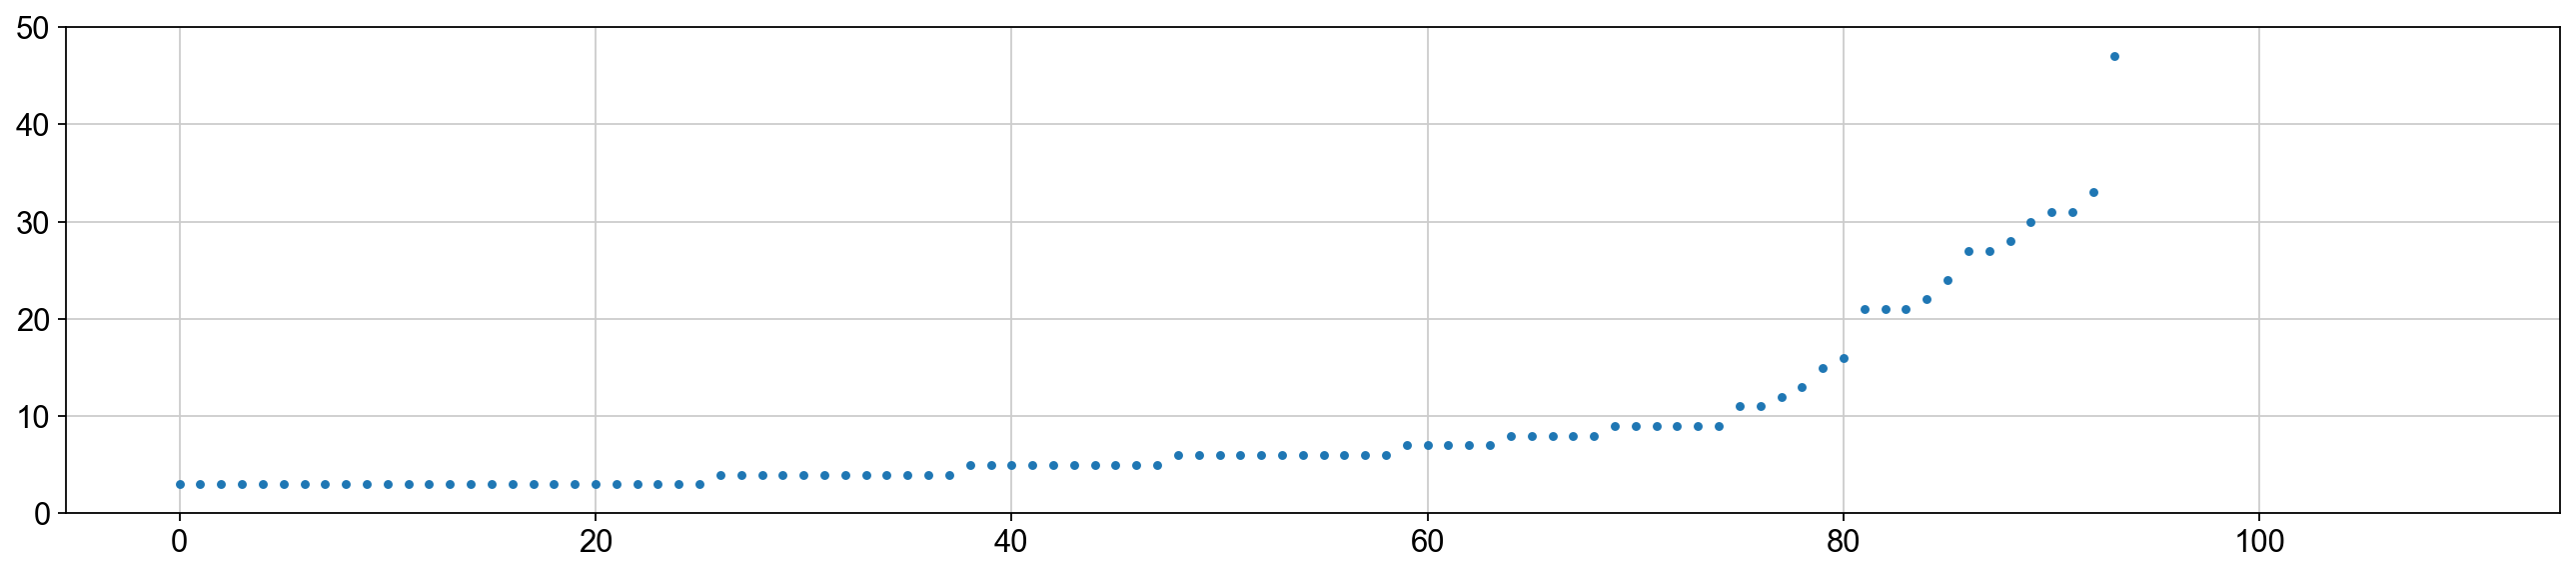

In [169]:
plt.plot(np.sort(cluster_df.cluster_size), '.')
plt.ylim([0,50])

In [170]:
adata_cluster.obs_names = [item1+'_'+item2 for item1, item2 in zip(adata_cluster.obs['target_contrast_corrected'], adata_cluster.obs['culture_condition'])]
adata_final = adata_de[adata_cluster.obs_names].copy()
adata_final.obs = adata_cluster.obs.copy()
adata_final.obs['hdbscan'] = adata_final.obs['hdbscan'].astype(int)
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(cluster_df[cluster_df['intracluster_corr']<0.2]['cluster']), 'hdbscan'] = -1
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(cluster_df[cluster_df['cluster_size']<5]['cluster']), 'hdbscan'] = -1
adata_final.obs['hdbscan'] = adata_final.obs['hdbscan'].astype('category')
adata_final = adata_final[adata_final.obs.hdbscan!=-1].copy()

In [171]:
adata_final

AnnData object with n_obs × n_vars = 2336 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan', 'hdbscan_cluster_size', 'hdbscan_cluster_gene_size'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [173]:
adata_final.write_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad')

In [6]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad')

In [34]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

In [35]:
len(adata_final.obs.hdbscan.unique())

72

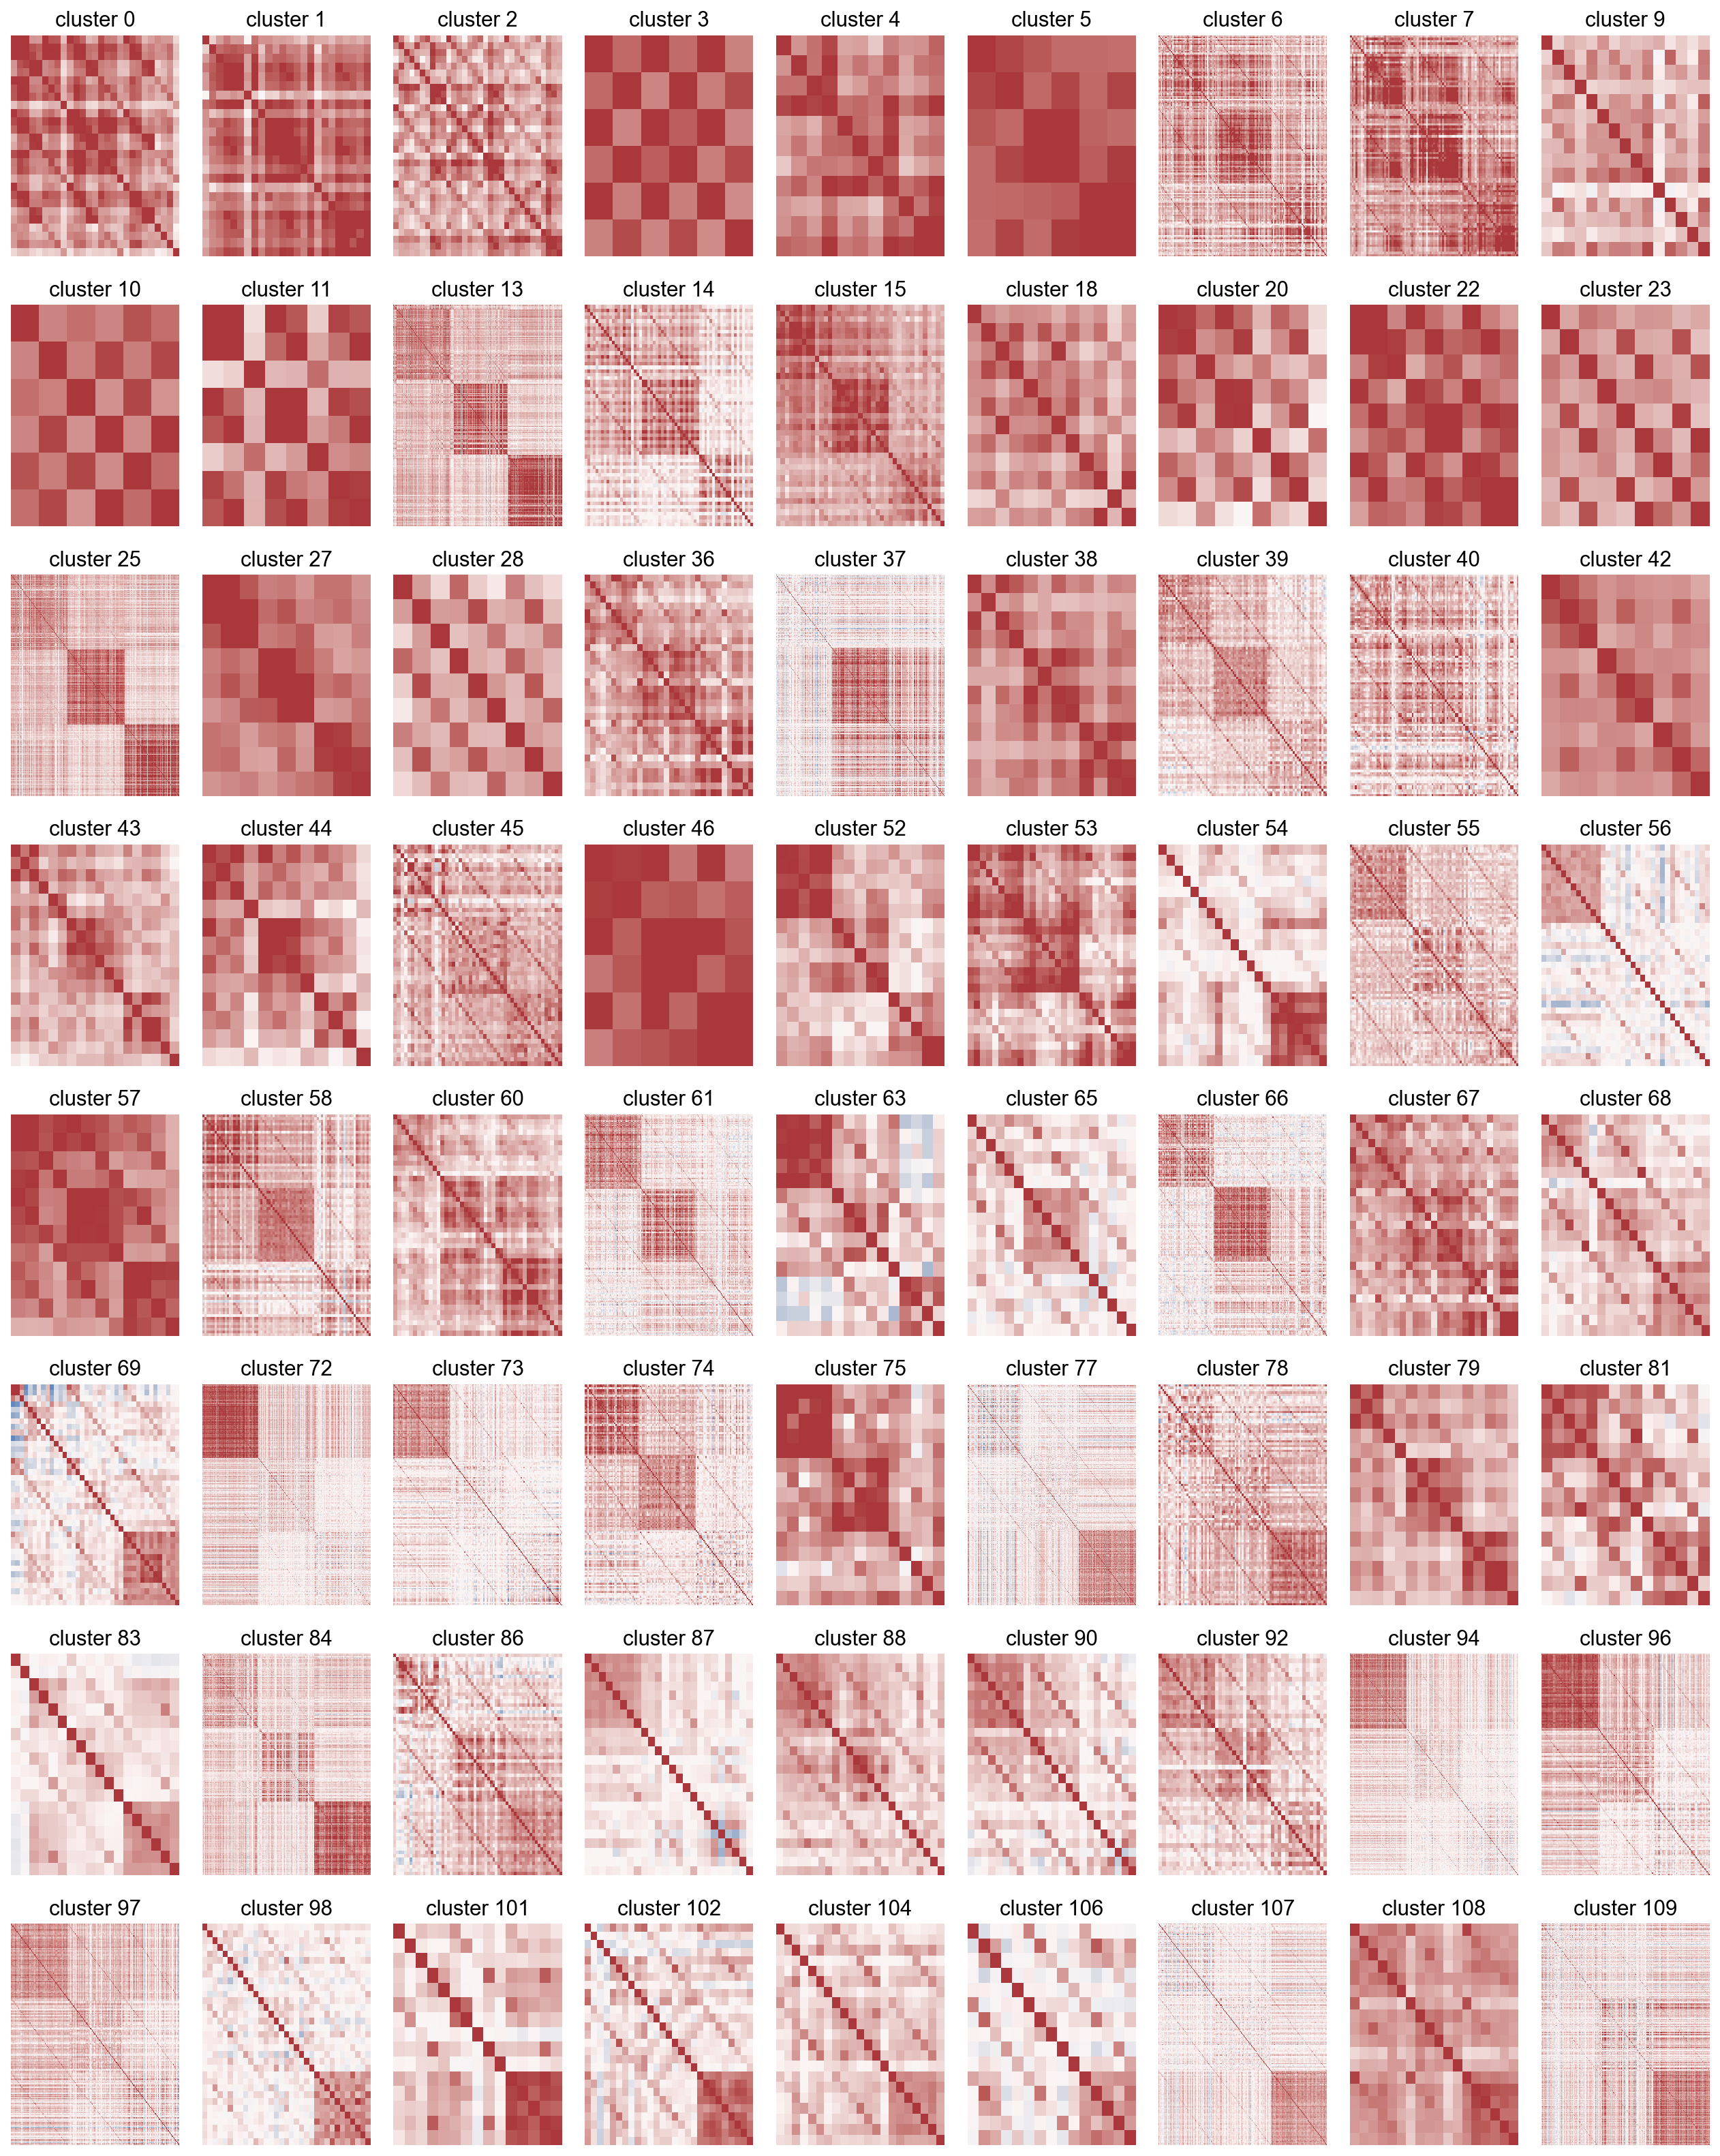

In [37]:
fig, axes = plt.subplots(8,9,figsize=(16,20))
ax = axes.flatten()
for i, cl in enumerate(adata_final.obs.hdbscan.unique().sort_values()):
    genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cl))
plt.tight_layout()

In [17]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad')

### Calculate condition specificity, annotate cluster size

In [174]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad')

In [175]:
adata_final.obs['hdbscan_corr_rest_over_corr_all'] = 1.0
adata_final.obs['hdbscan_corr_stim8hr_over_corr_all'] = 1.0
adata_final.obs['hdbscan_corr_stim48hr_over_corr_all'] = 1.0

In [176]:
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_gene_name_corrected'].isin(genelist)].layers['zscore'].T).corr()

In [177]:
for cl in adata_final.obs['hdbscan'].unique():

    genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
    
    corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_gene_name_corrected'].isin(genelist)].layers['zscore'].T).corr()
    corr_median = np.median(corr_all.values[np.tril_indices_from(corr_all.values, k=-1)])
    
    corr_rest = pd.DataFrame(adata_de[(adata_de.obs['target_contrast_gene_name_corrected'].isin(genelist))&(adata_de.obs['culture_condition']=='Rest')].layers['zscore'].T).corr()
    corr_median_rest = np.median(corr_rest.values[np.tril_indices_from(corr_rest.values, k=-1)])
    
    corr_stim8hr = pd.DataFrame(adata_de[(adata_de.obs['target_contrast_gene_name_corrected'].isin(genelist))&(adata_de.obs['culture_condition']=='Stim8hr')].layers['zscore'].T).corr()
    corr_median_stim8hr = np.median(corr_stim8hr.values[np.tril_indices_from(corr_stim8hr.values, k=-1)])
    
    corr_stim48hr = pd.DataFrame(adata_de[(adata_de.obs['target_contrast_gene_name_corrected'].isin(genelist))&(adata_de.obs['culture_condition']=='Stim48hr')].layers['zscore'].T).corr()
    corr_median_stim48hr = np.median(corr_stim48hr.values[np.tril_indices_from(corr_stim48hr.values, k=-1)])

    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_rest_over_corr_all'] = corr_median_rest/corr_median
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim8hr_over_corr_all'] = corr_median_stim8hr/corr_median
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim48hr_over_corr_all'] = corr_median_stim48hr/corr_median

In [178]:
adata_final.write_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad')

In [211]:
condition_specificity = adata_final.obs[['hdbscan', 'hdbscan_cluster_gene_size', 'hdbscan_corr_rest_over_corr_all',
                                         'hdbscan_corr_stim8hr_over_corr_all', 'hdbscan_corr_stim48hr_over_corr_all']].drop_duplicates().sort_values(by='hdbscan').set_index('hdbscan', drop=True)
condition_specificity = condition_specificity[condition_specificity['hdbscan_cluster_gene_size']>5].iloc[:,1:]

In [212]:
len(condition_specificity)

48

In [215]:
len(hdbscan_order)

47

In [216]:
set(condition_specificity.index) - set(hdbscan_order)

{69}

In [217]:
hdbscan_order = np.array([0, 1, 2, 6, 7, 
                          14, 13, 25, 84, 
                          15, 
                          36, 60, 67, 
                          40, 53, 
                          43, 
                          97, 108,
                          39, 45, 55, 68, 78, 86, 92, # unknown, not specific
                          56,
                          73, 87, 94, 58, # cell cycle upstream
                          65, # unknown, stim8hr
                          61, 66, 74, 88, # unknown, rest & stim8hr
                          72, 90, 96, # unknown, rest
                          54, # stim48hr
                          98, # stim48hr
                          69, # stim48hr
                          107,
                          37, 109, 
                          77, 83, 102, 104]) # unknown, stim48hr

In [218]:
cm = sns.clustermap(condition_specificity.iloc[:,1:], figsize=(3,15), vmin=0, vmax=5)
plt.close()
vrange = [0, 5]

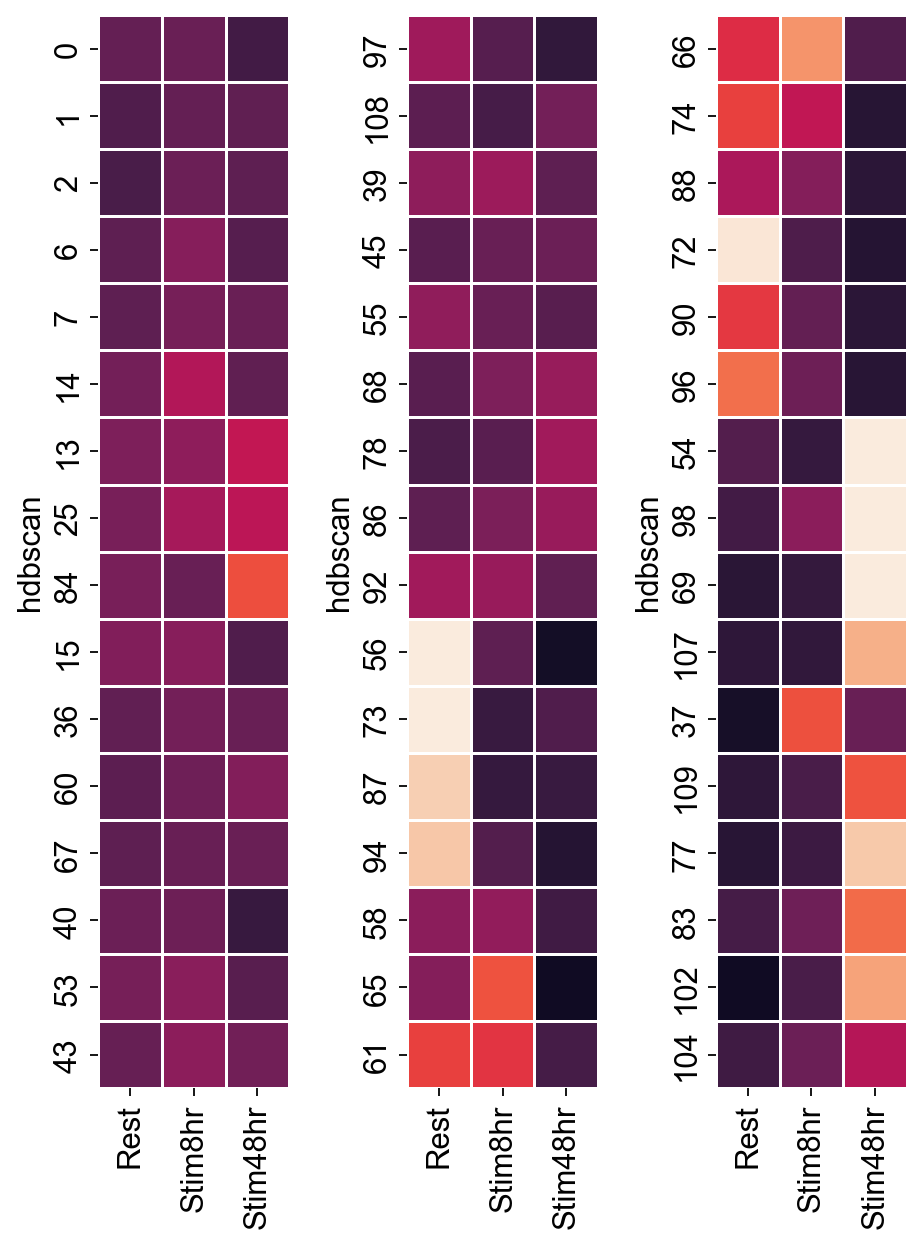

In [219]:
fig, ax = plt.subplots(1,3,figsize=(6,8))
sns.heatmap(condition_specificity.loc[hdbscan_order[:16]], ax=ax[0], vmin=vrange[0], vmax=vrange[1], cbar=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], linewidth=0.5)
ax[0].grid(False)
sns.heatmap(condition_specificity.loc[hdbscan_order[16:32]], ax=ax[1], vmin=vrange[0], vmax=vrange[1], cbar=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], linewidth=0.5)
ax[1].grid(False)
sns.heatmap(condition_specificity.loc[hdbscan_order[32:48]], ax=ax[2], vmin=vrange[0], vmax=vrange[1], cbar=False, xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], linewidth=0.5)
ax[2].grid(False)
plt.tight_layout()
plt.savefig('./results/condition_specificity.png')

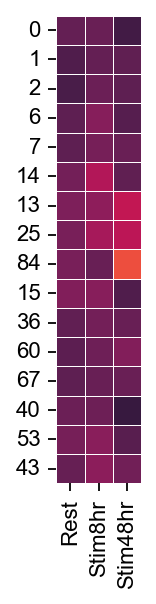

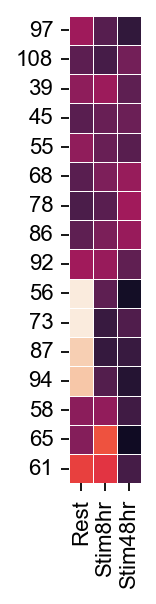

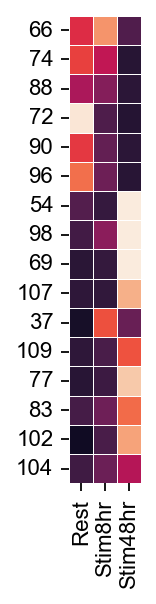

In [242]:
fig, ax = plt.subplots(figsize=(1.2,4))
sns.heatmap(condition_specificity.loc[hdbscan_order[:16]], ax=ax, vmin=vrange[0], vmax=vrange[1], cbar=False,
            xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], yticklabels=True, linewidth=0.25)
ax.tick_params(labelsize=10)
ax.set_ylabel('')
ax.grid(False)
plt.tight_layout()
plt.savefig('./results/condition_specificity_1.png')

fig, ax = plt.subplots(figsize=(1.2,4))
sns.heatmap(condition_specificity.loc[hdbscan_order[16:32]], ax=ax, vmin=vrange[0], vmax=vrange[1], cbar=False,
            xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], yticklabels=True, linewidth=0.25)
ax.tick_params(labelsize=10)
ax.set_ylabel('')
ax.grid(False)
plt.tight_layout()
plt.savefig('./results/condition_specificity_2.png')

fig, ax = plt.subplots(figsize=(1.2,4))
sns.heatmap(condition_specificity.loc[hdbscan_order[32:48]], ax=ax, vmin=vrange[0], vmax=vrange[1], cbar=False,
            xticklabels=['Rest', 'Stim8hr', 'Stim48hr'], yticklabels=True, linewidth=0.25)
ax.tick_params(labelsize=10)
ax.set_ylabel('')
ax.grid(False)
plt.tight_layout()
plt.savefig('./results/condition_specificity_3.png')

In [244]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

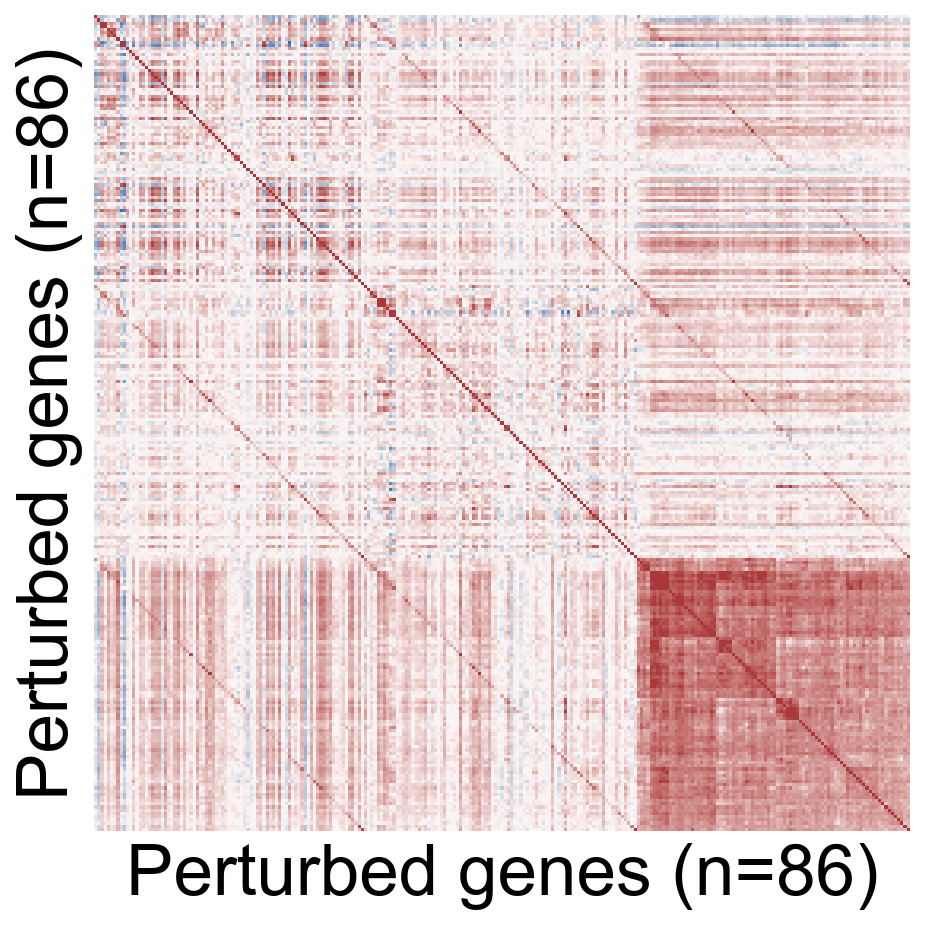

In [252]:
cl = 107
thres = 0.4
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', xticklabels=False, yticklabels=False, cbar=False)
plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
plt.savefig('./results/cluster'+str(cl)+'.png')

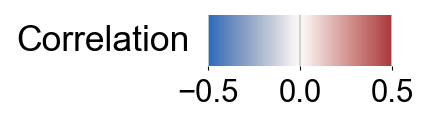

In [248]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time
import matplotlib as mpl

thres = 0.5
cmap = sns.color_palette("vlag", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(3, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=14, width=0.5, length=2)
cb.set_ticks([-thres, 0, thres])

# Add "Correlation" label on the left
ax.text(-0.1, 0.5, "Correlation", fontsize=16, va='center', ha='right', transform=ax.transAxes)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar'+str(thres)+'.png')

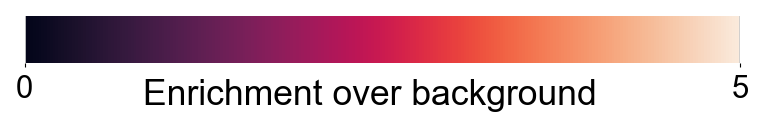

In [274]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time
import matplotlib as mpl

cmap = sns.color_palette("rocket", as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=5)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(5, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=14, width=0.5, length=2)
cb.set_ticks([0, 5])

# Add "Correlation" label on the left
ax.text(0.8, -0.7, "Enrichment over background", fontsize=16, va='center', ha='right', transform=ax.transAxes)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
#plt.savefig('./results/colorbar'+str(thres)+'.png')

In [107]:
adata_final[adata_final.obs.hdbscan==78].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000181090_Stim48hr                     EHMT1          Stim48hr   
ENSG00000204371_Stim48hr                     EHMT2          Stim48hr   
ENSG00000011451_Stim48hr                       WIZ          Stim48hr   
ENSG00000122482_Stim48hr                    ZNF644          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000181090_Stim48hr  ENSG00000181090   438          1626.0   
ENSG00000204371_Stim48hr  ENSG00000204371   324           629.0   
ENSG00000011451_Stim48hr  ENSG00000011451   504          1115.0   
ENSG00000122482_Stim48hr  ENSG00000122482   414           591.0   

                         target_contrast_corrected  \
ENSG00000181090_Stim48hr           ENSG00000181090   
ENSG00000204371_Stim48hr           ENSG00000204371   
ENSG00000011451_Stim48hr           ENSG00000011451   
ENSG00000122482_Stim48hr           ENSG00000122482   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000181090_Stim48hr                               EHMT1      78  
ENSG00000204371_Stim48hr                               EHMT2      78  
ENSG00000011451_Stim48hr                                 WIZ      78  
ENSG00000122482_Stim48hr                              ZNF644      78

In [104]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.str.startswith('LCK')].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000182866_Stim8hr                        LCK           Stim8hr   
ENSG00000182866_Stim48hr                       LCK          Stim48hr   
ENSG00000182866_Rest                           LCK              Rest   

                          target_contrast chunk  n_cells_target  \
ENSG00000182866_Stim8hr   ENSG00000182866    59           116.0   
ENSG00000182866_Stim48hr  ENSG00000182866   432           107.0   
ENSG00000182866_Rest      ENSG00000182866   459           102.0   

                         target_contrast_corrected  \
ENSG00000182866_Stim8hr            ENSG00000182866   
ENSG00000182866_Stim48hr           ENSG00000182866   
ENSG00000182866_Rest               ENSG00000182866   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000182866_Stim8hr                                  LCK      36  
ENSG00000182866_Stim48hr                                 LCK     101  
ENSG00000182866_Rest                                     LCK      90

target_contrast target_name condition  n_cells_target  n_up_genes  \
2370   ENSG00000128683        GAD1  Stim48hr           733.0           0   
12462  ENSG00000128683        GAD1   Stim8hr           673.0           1   
31086  ENSG00000128683        GAD1      Rest           723.0           2   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2370              1                 1             -6.418918   
12462             1                 2             -4.389556   
31086             0                 2             -2.358590   

       ontarget_significant  baseMean  offtarget_flag n_total_genes_category  \
2370                   True  9.808407           False              1 DE gene   
12462                  True  4.670098           False          2-10 DE genes   
31086                 False  1.034175           False          2-10 DE genes   

      ontarget_effect_category target_contrast_corrected  \
2370              on-target KD           ENSG00000128683   
12462             on-target KD           ENSG00000128683   
31086          no on-target KD           ENSG00000128683   

                      obs_names target_name_corrected  
2370   ENSG00000128683_Stim48hr                  GAD1  
12462   ENSG00000128683_Stim8hr                  GAD1  
31086      ENSG00000128683_Rest                  GAD1

In [98]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name=='ITK'].obs

target_contrast_gene_name culture_condition  \
ENSG00000113263_Stim8hr                        ITK           Stim8hr   
ENSG00000113263_Stim48hr                       ITK          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000113263_Stim8hr   ENSG00000113263   443           517.0   
ENSG00000113263_Stim48hr  ENSG00000113263   610           361.0   

                         target_contrast_corrected  \
ENSG00000113263_Stim8hr            ENSG00000113263   
ENSG00000113263_Stim48hr           ENSG00000113263   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000113263_Stim8hr                                  ITK      36  
ENSG00000113263_Stim48hr                                 ITK     101

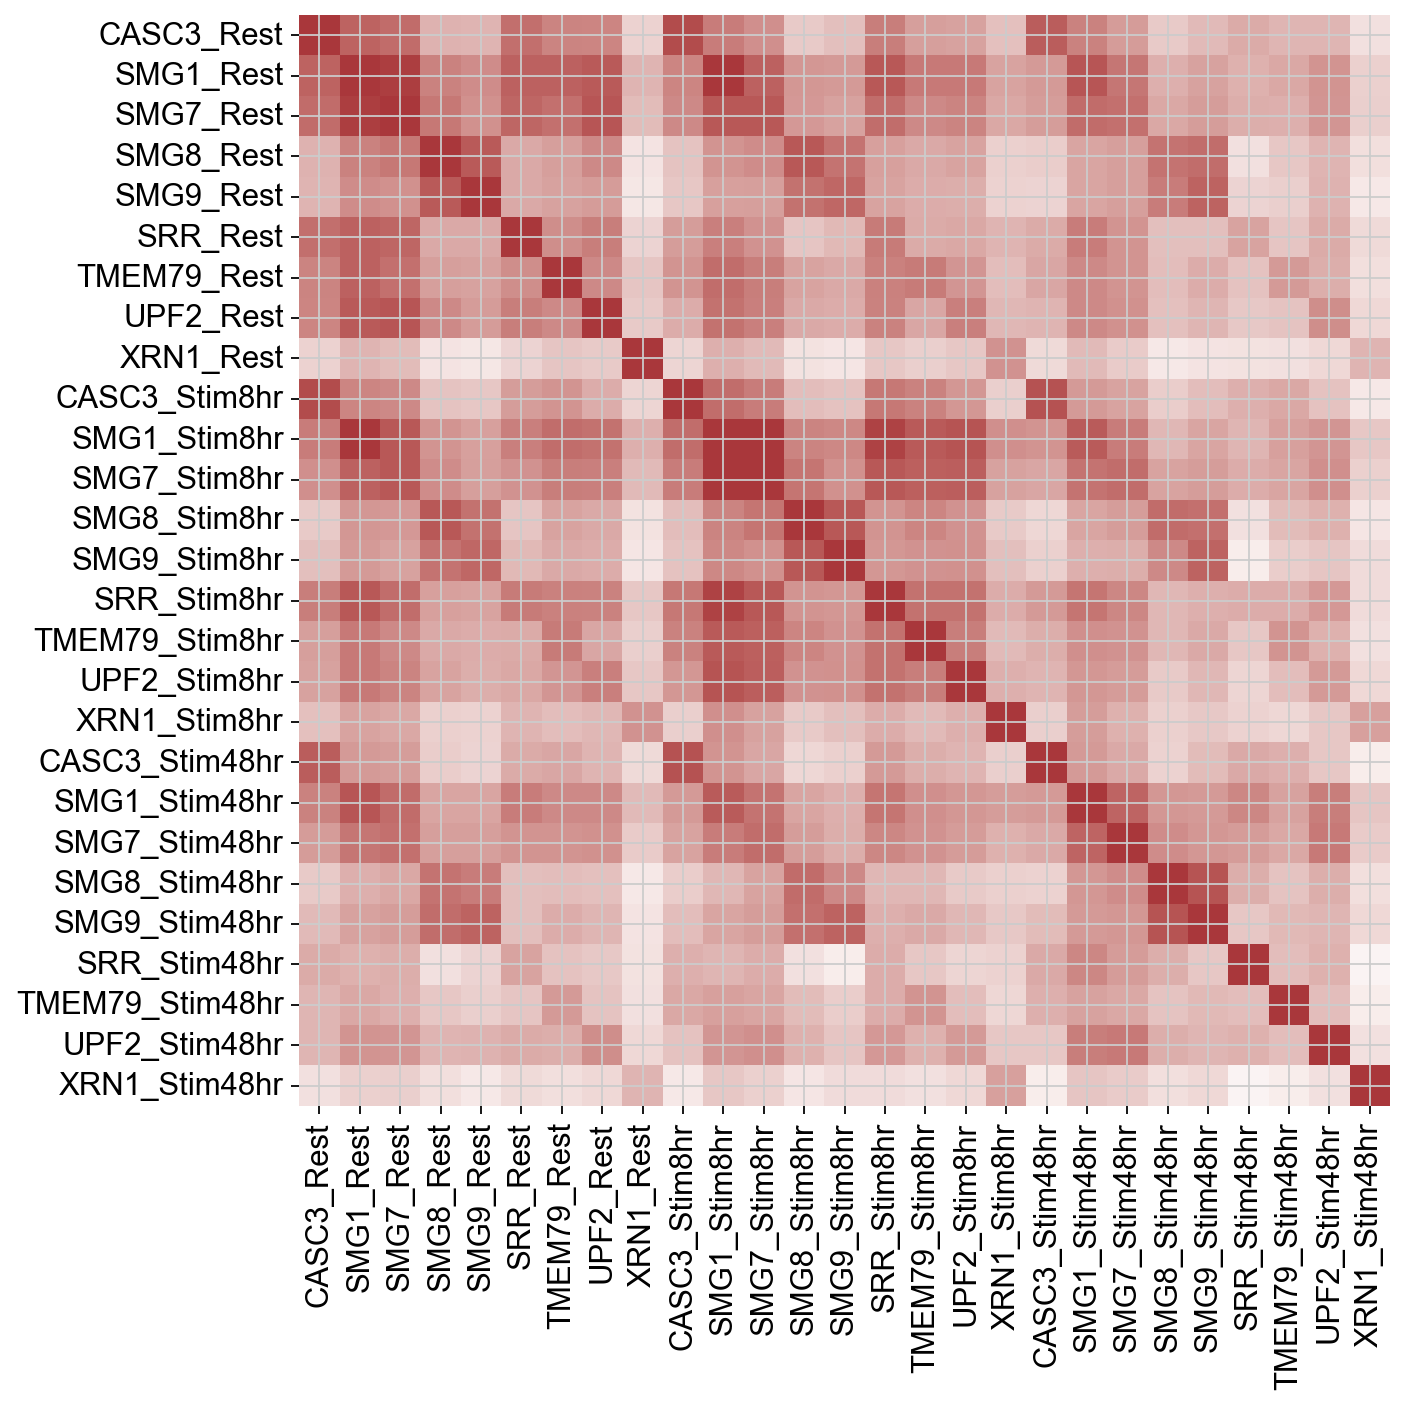

In [115]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==7].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster7.png')

In [22]:
len(genelist)

195

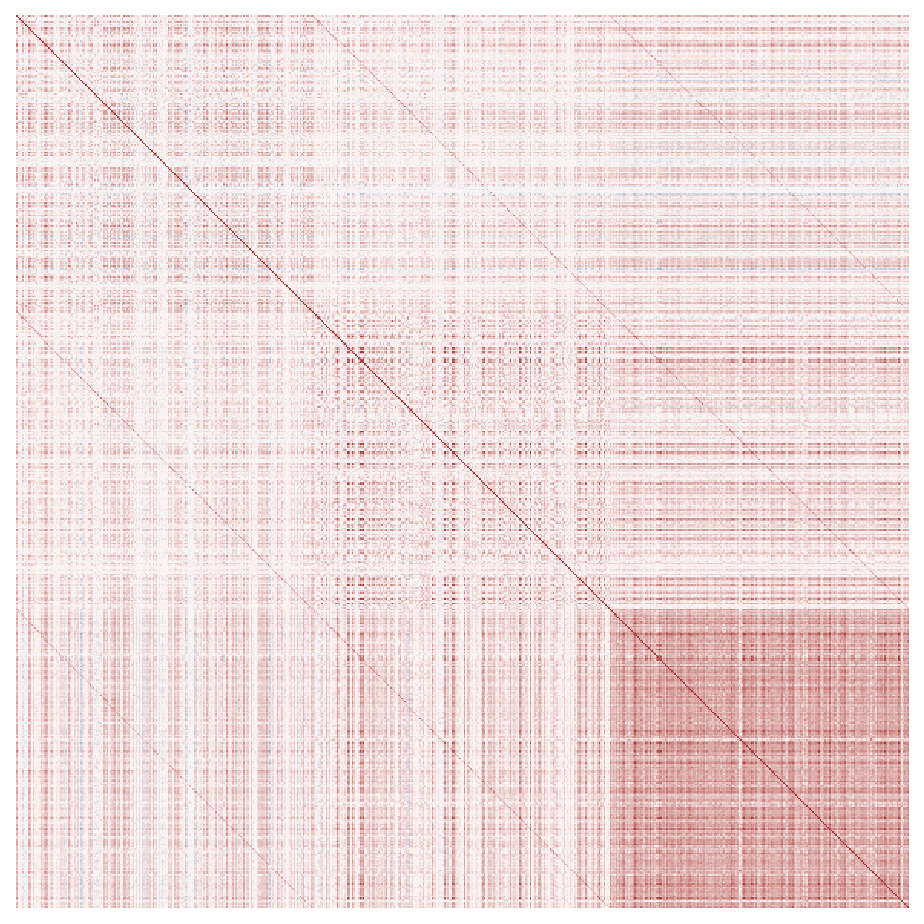

In [18]:
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==101].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False, xticklabels=False, yticklabels=False)
plt.tight_layout()
plt.savefig('results/cluster101.png')

In [89]:
adata_final[adata_final.obs.hdbscan==25].obs.target_contrast_gene_name_corrected.unique().tolist()

['SLC25A1', 'PDHB', 'MDH2', 'DLAT', 'PDHA1', 'CS', 'ACLY', 'STYXL1']

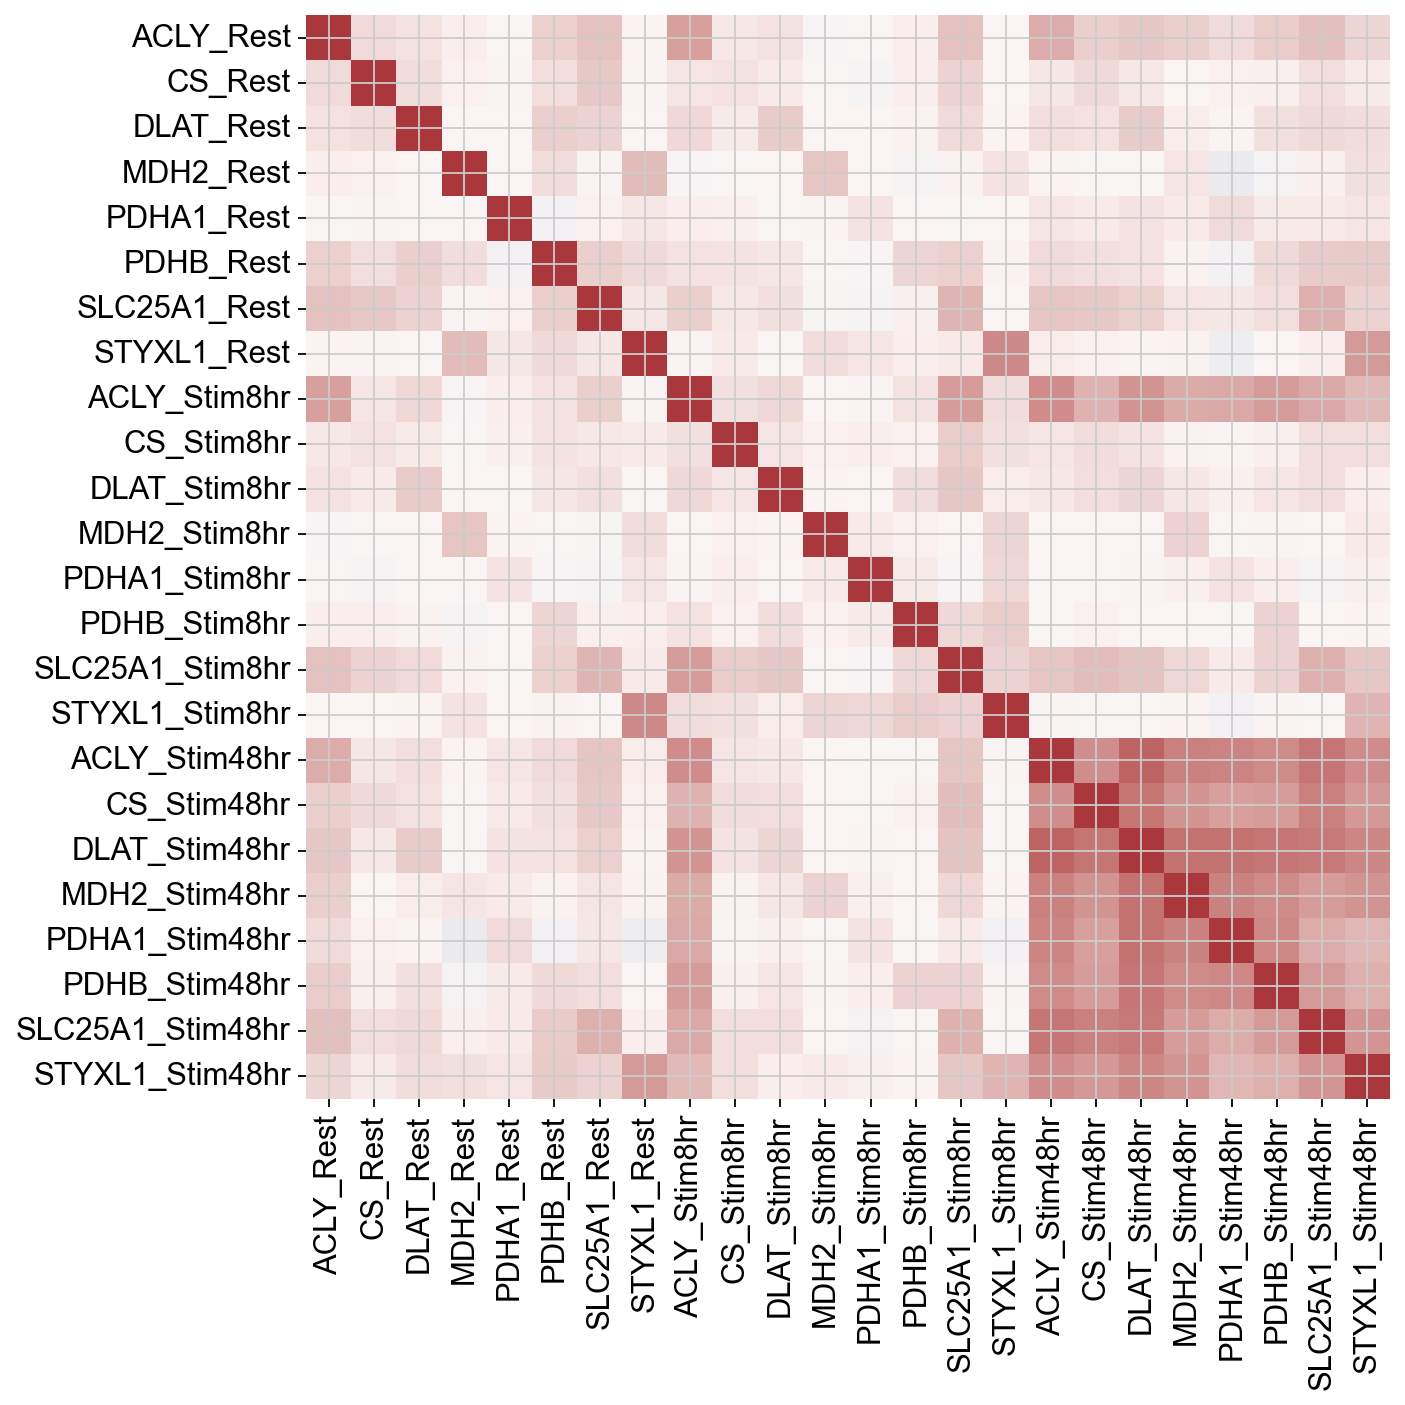

In [85]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==25].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster25.png')

In [103]:
de_summary_stats[de_summary_stats.target_name=='LCK']

target_contrast target_name condition  n_cells_target  n_up_genes  \
2984   ENSG00000182866         LCK   Stim8hr           116.0        1745   
21628  ENSG00000182866         LCK  Stim48hr           107.0         613   
22978  ENSG00000182866         LCK      Rest           102.0         103   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2984            669              2414             -8.989515   
21628           303               916             -9.689431   
22978           206               309            -10.907615   

       ontarget_significant    baseMean  offtarget_flag  \
2984                   True  129.013733           False   
21628                  True  160.513650           False   
22978                  True  205.543259           False   

      n_total_genes_category ontarget_effect_category  \
2984            >10 DE genes             on-target KD   
21628           >10 DE genes             on-target KD   
22978           >10 DE genes             on-target KD   

      target_contrast_corrected                 obs_names  \
2984            ENSG00000182866   ENSG00000182866_Stim8hr   
21628           ENSG00000182866  ENSG00000182866_Stim48hr   
22978           ENSG00000182866      ENSG00000182866_Rest   

      target_name_corrected  
2984                    LCK  
21628                   LCK  
22978                   LCK

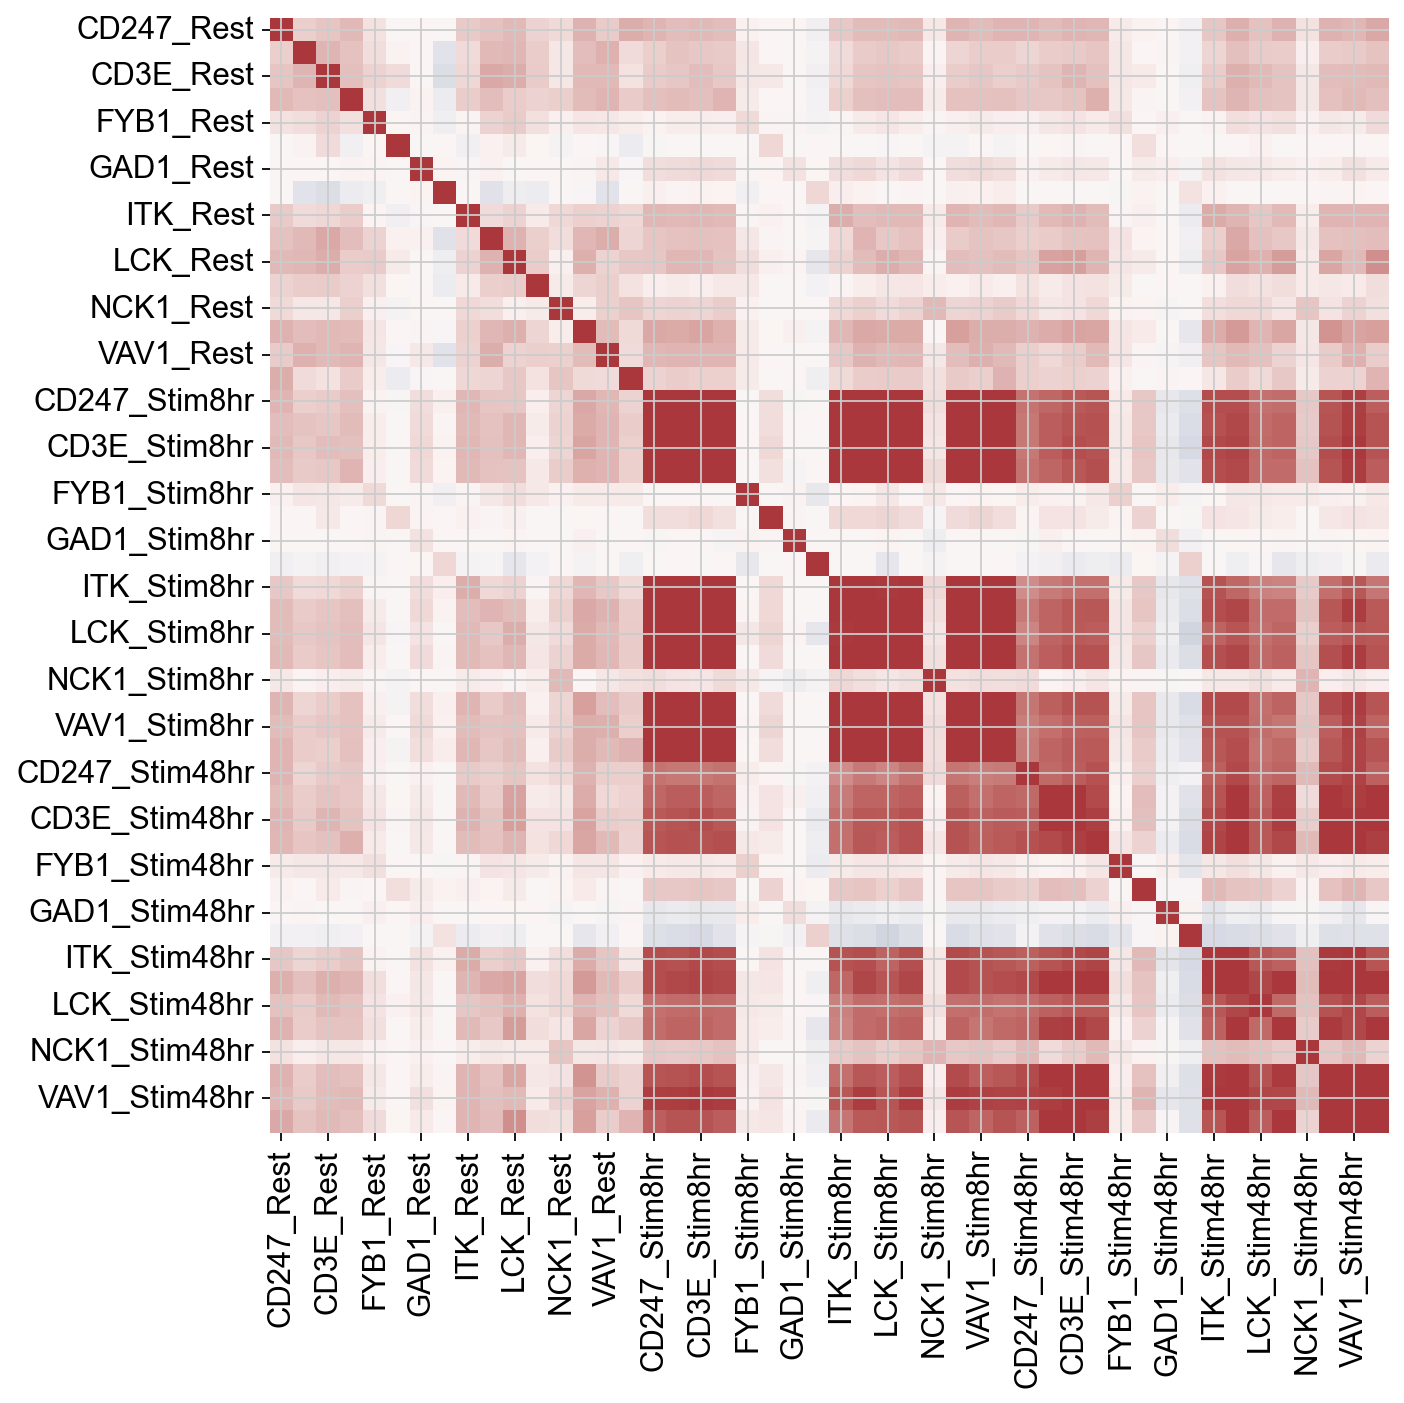

In [105]:
plt.figure(figsize=(9, 9))
genelist = adata_final[(adata_final.obs.hdbscan==29)&(adata_final.obs.target_contrast_gene_name!='BCAT2')&(adata_final.obs.target_contrast_gene_name!='ZBED3')].obs.target_contrast_gene_name_corrected.unique().tolist()
genelist = genelist + ['GRB2', 'GAD1', 'ITK', 'NCK1', 'FYB1', 'FYN', 'LCK']
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster29.png')

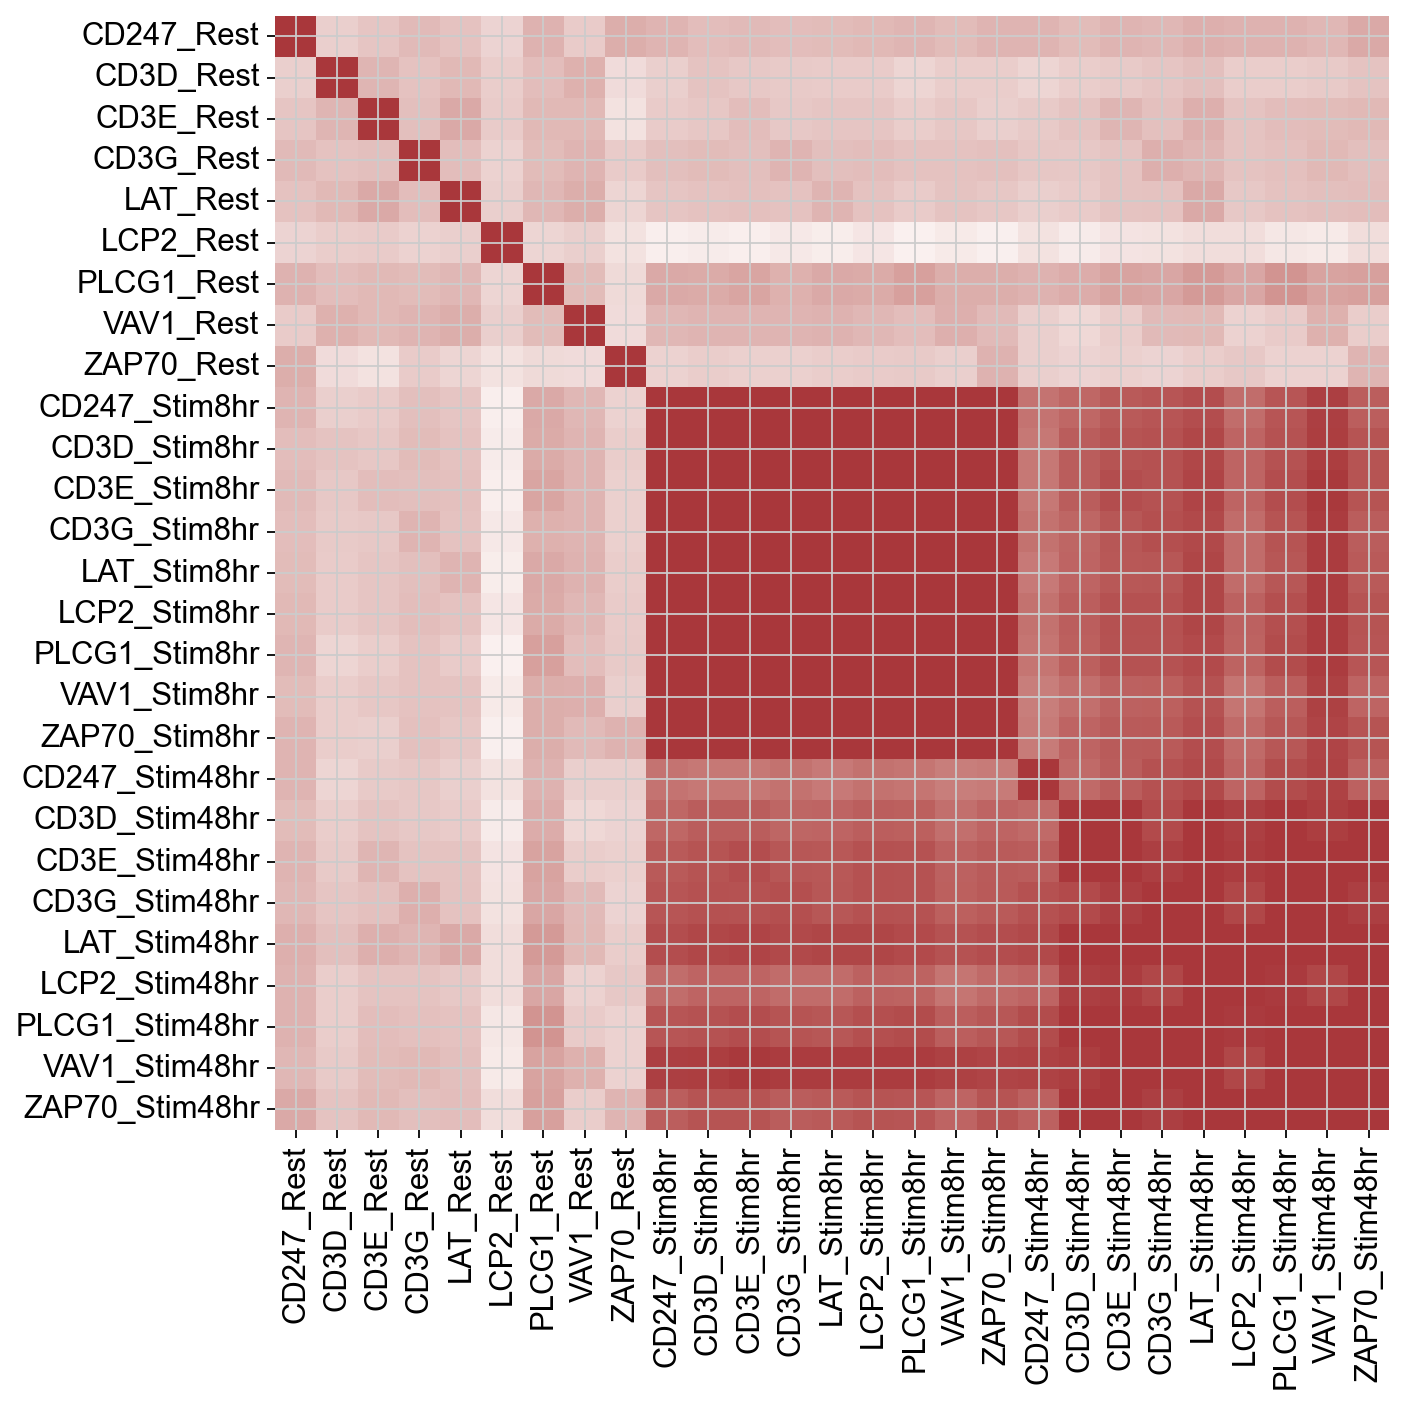

In [106]:
plt.figure(figsize=(9, 9))
genelist = adata_final[(adata_final.obs.hdbscan==29)&(adata_final.obs.target_contrast_gene_name!='BCAT2')&(adata_final.obs.target_contrast_gene_name!='ZBED3')].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster29.png')

In [44]:
de_summary_stats[de_summary_stats.target_name=='KDM5']

Empty DataFrame
Columns: [target_contrast, target_name, condition, n_cells_target, n_up_genes, n_down_genes, n_total_de_genes, ontarget_effect_size, ontarget_significant, baseMean, offtarget_flag, n_total_genes_category, ontarget_effect_category, target_contrast_corrected, obs_names, target_name_corrected]
Index: []

In [38]:
de_summary_stats[de_summary_stats.target_name=='BDH1']

target_contrast target_name condition  n_cells_target  n_up_genes  \
6623   ENSG00000161267        BDH1  Stim48hr           762.0           0   
25369  ENSG00000161267        BDH1   Stim8hr           670.0           1   
30701  ENSG00000161267        BDH1      Rest           775.0           0   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
6623              1                 1            -15.532728   
25369             1                 2            -12.591295   
30701             2                 2            -10.268499   

       ontarget_significant   baseMean  offtarget_flag n_total_genes_category  \
6623                   True  43.655616           False              1 DE gene   
25369                  True  35.456898           False          2-10 DE genes   
30701                  True  17.266753           False          2-10 DE genes   

      ontarget_effect_category target_contrast_corrected  \
6623              on-target KD           ENSG00000161267   
25369             on-target KD           ENSG00000161267   
30701             on-target KD           ENSG00000161267   

                      obs_names target_name_corrected  
6623   ENSG00000161267_Stim48hr                  BDH1  
25369   ENSG00000161267_Stim8hr                  BDH1  
30701      ENSG00000161267_Rest                  BDH1

In [35]:
adata_de[adata_de.obs.target_contrast_gene_name_corrected=='BDH1']

View of AnnData object with n_obs × n_vars = 3 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [34]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='BDH1']

View of AnnData object with n_obs × n_vars = 0 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

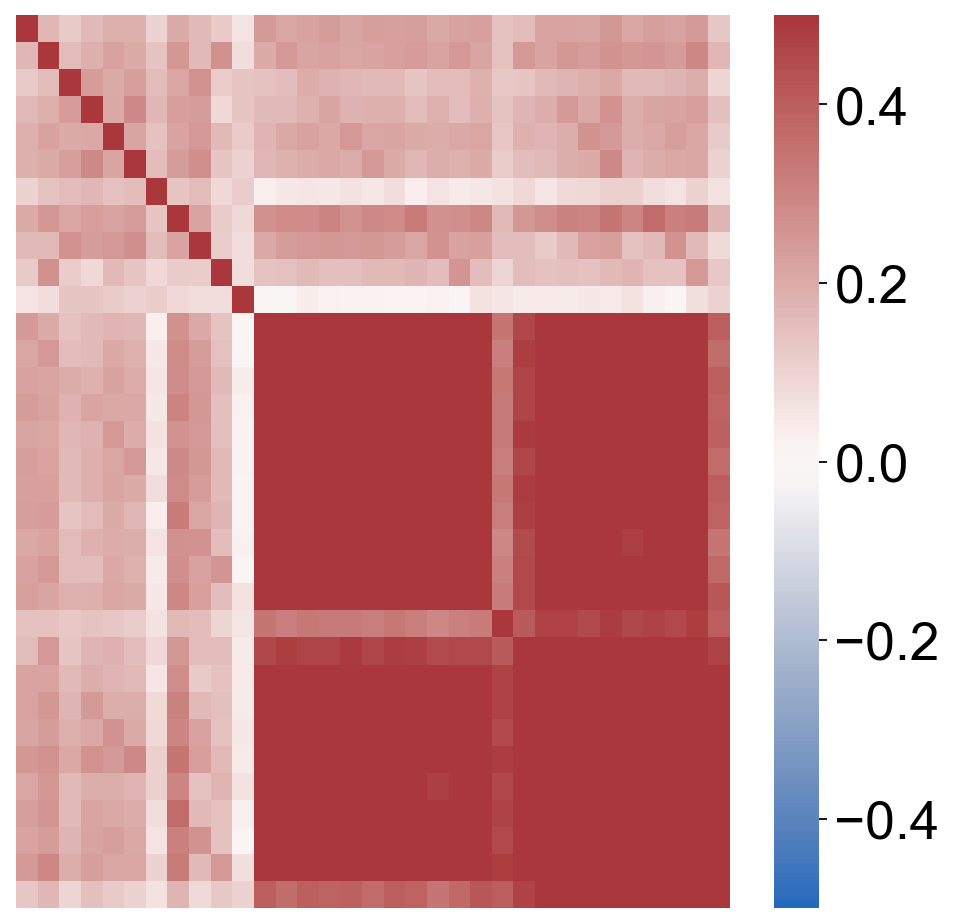

In [32]:
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==29].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
ax = sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', xticklabels=False, yticklabels=False, cbar=True)
plt.tight_layout()
cbar = ax.collections[0].colorbar  
cbar.ax.tick_params(labelsize=24)
plt.savefig('results/colorbar0.5.png')

In [37]:
cluster_df[(cluster_df.intracluster_corr<0.2)&(cluster_df.cluster_gene_size>=5)]

cluster  intracluster_corr  cluster_size  cluster_gene_size  \
25       25           0.140295          21.0                9.0   
30       30           0.168900          16.0                8.0   
37       37           0.171560           7.0                6.0   
42       42           0.178128          11.0               11.0   
46       46           0.163973          99.0               57.0   
47       47           0.150139          15.0               15.0   
50       50           0.188514          45.0               44.0   
54       54           0.054538          45.0               27.0   
58       58           0.184500           6.0                6.0   
59       59           0.172770          40.0               40.0   
60       60           0.107564          70.0               69.0   
61       61           0.144730          27.0               19.0   
62       62           0.196344          74.0               73.0   
66       66           0.081469          12.0               12.0   
67       67           0.142190          17.0               14.0   
72       72           0.102889           7.0                7.0   
76       76           0.018664          52.0               45.0   
77       77           0.081563           8.0                5.0   
79       79           0.121424           6.0                6.0   
80       80           0.141374          11.0               11.0   
81       81           0.184018           5.0                5.0   
82       82           0.170182          17.0               17.0   
84       84           0.154942          73.0               73.0   
88       88           0.176332          21.0               21.0   
89       89           0.128020          15.0               15.0   
90       90           0.176932           5.0                5.0   
91       91           0.165445          72.0               72.0   
92       92           0.172595          10.0               10.0   
96       96           0.196787          80.0               79.0   
97       97           0.163416          14.0               14.0   

                                       cluster_member  
25  [CDKN2AIP, RBM12, WDR82, UBE3D, DNAAF2, DOP1A,...  
30  [ZFC3H1, THAP2, GPR137, ZC3H3, GPAA1, ZNF330, ...  
37         [PIBF1, BCLAF1, C1D, TTC5, FAM161A, STIM1]  
42  [PDCL, RICTOR, CBFB, POLDIP3, AGRN, EMC4, ZAP7...  
46  [TMEM131L, ACAD11, DDRGK1, CALR, ALG6, TGDS, D...  
47  [FLI1, SENP1, ELP6, EMX1, TMEM185A, MBTPS1, TM...  
50  [KLHDC10, ICOS, NEIL1, PXMP4, ZNF641, HPF1, CA...  
54  [CNOT11, TSTD2, SETD1B, PCYT2, WAC, CXXC1, KLF...  
58          [CREBBP, EP300, EME2, CBFB, KDM3B, CDCA3]  
59  [NIPBL, PXMP4, PDIA3, HSD17B13, ALKBH2, AK3, C...  
60  [IDH3A, SLC25A51, FAM20B, BRD1, PGS1, CMAS, IR...  
61  [KMT2C, RAB27B, SMARCC1, SMARCA4, SMARCB1, BHL...  
62  [FEM1A, PTPN1, NRBP1, CSK, APOBEC3B, UBXN1, CC...  
66  [MCEE, SPAG7, CWC27, PFAS, RAB27B, NAA40, ZFX,...  
67  [GIGYF2, TESPA1, TBL1X, DTX4, APOBEC3B, PRR12,...  
72  [JAKMIP2, IMMP2L, SUGP1, GCN1, ZNF254, ARL5B, ...  
76  [CDK5RAP3, NDUFB11, BLOC1S2, PAN3, SRSF6, PRPF...  
77                [CCDC6, GPR63, CARM1, ATP23, PA2G4]  
79             [PPP6C, RHEB, CYLD, CCR6, APC, POU3F1]  
80  [TMED9, TESK2, GNG5, MFSD6, SLC35B1, STK11, RB...  
81                   [SKIC3, TXNDC9, ARSK, AVEN, C1S]  
82  [CMTM7, SMAD3, AK3, RASGRP1, ICOS, ARMC8, FBXO...  
84  [ZNF574, GIGYF2, SP100, MAPK14, RRM2B, GLS, CL...  
88  [RHBDD3, MBIP, DMXL1, MTHFD1L, ZNF622, CLUH, R...  
89  [DEF8, SYNCRIP, USP10, DDX31, UBXN6, RBCK1, AT...  
90                [IPMK, PAICS, STAT3, IL21R, PABIR1]  
91  [ANKRD49, PHF3, XRCC2, STK11, RBM5, SIK3, STYX...  
92  [MFN2, PRUNE1, PPP1R11, GMEB2, UROS, DLD, TP53...  
96  [LMTK2, DUSP12, RBM27, NAF1, SARNP, CYTH3, GTF...  
97  [HSPA8, RSBN1L, SNRPB2, EIF3L, ANKRD11, PPIH, ...

In [69]:
adata_final[adata_final.obs.hdbscan==17].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000131473_Stim48hr                      ACLY          Stim48hr   
ENSG00000131473_Stim8hr                       ACLY           Stim8hr   
ENSG00000062485_Stim48hr                        CS          Stim48hr   
ENSG00000150768_Stim48hr                      DLAT          Stim48hr   
ENSG00000146701_Stim48hr                      MDH2          Stim48hr   
ENSG00000131828_Stim48hr                     PDHA1          Stim48hr   
ENSG00000168291_Stim48hr                      PDHB          Stim48hr   
ENSG00000138621_Rest                         PPCDC              Rest   
ENSG00000138621_Stim8hr                      PPCDC           Stim8hr   
ENSG00000127125_Rest                          PPCS              Rest   
ENSG00000127125_Stim8hr                       PPCS           Stim8hr   
ENSG00000100075_Stim48hr                   SLC25A1          Stim48hr   
ENSG00000127952_Stim48hr                    STYXL1          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000131473_Stim48hr  ENSG00000131473   570           282.0   
ENSG00000131473_Stim8hr   ENSG00000131473   645           396.0   
ENSG00000062485_Stim48hr  ENSG00000062485   469           232.0   
ENSG00000150768_Stim48hr  ENSG00000150768   392           372.0   
ENSG00000146701_Stim48hr  ENSG00000146701   182           998.0   
ENSG00000131828_Stim48hr  ENSG00000131828   454           192.0   
ENSG00000168291_Stim48hr  ENSG00000168291   155           303.0   
ENSG00000138621_Rest      ENSG00000138621   198           575.0   
ENSG00000138621_Stim8hr   ENSG00000138621   657           599.0   
ENSG00000127125_Rest      ENSG00000127125    41           137.0   
ENSG00000127125_Stim8hr   ENSG00000127125    97           138.0   
ENSG00000100075_Stim48hr  ENSG00000100075   102           521.0   
ENSG00000127952_Stim48hr  ENSG00000127952   671           753.0   

                         target_contrast_corrected  \
ENSG00000131473_Stim48hr           ENSG00000131473   
ENSG00000131473_Stim8hr            ENSG00000131473   
ENSG00000062485_Stim48hr           ENSG00000062485   
ENSG00000150768_Stim48hr           ENSG00000150768   
ENSG00000146701_Stim48hr           ENSG00000146701   
ENSG00000131828_Stim48hr           ENSG00000131828   
ENSG00000168291_Stim48hr           ENSG00000168291   
ENSG00000138621_Rest               ENSG00000138621   
ENSG00000138621_Stim8hr            ENSG00000138621   
ENSG00000127125_Rest               ENSG00000127125   
ENSG00000127125_Stim8hr            ENSG00000127125   
ENSG00000100075_Stim48hr           ENSG00000100075   
ENSG00000127952_Stim48hr           ENSG00000127952   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000131473_Stim48hr                                ACLY      17  
ENSG00000131473_Stim8hr                                 ACLY      17  
ENSG00000062485_Stim48hr                                  CS      17  
ENSG00000150768_Stim48hr                                DLAT      17  
ENSG00000146701_Stim48hr                                MDH2      17  
ENSG00000131828_Stim48hr                               PDHA1      17  
ENSG00000168291_Stim48hr                                PDHB      17  
ENSG00000138621_Rest                                   PPCDC      17  
ENSG00000138621_Stim8hr                                PPCDC      17  
ENSG00000127125_Rest                                    PPCS      17  
ENSG00000127125_Stim8hr                                 PPCS      17  
ENSG00000100075_Stim48hr                             SLC25A1      17  
ENSG00000127952_Stim48hr                              STYXL1      17

In [633]:
ind1 = np.where(adata.obs.index.isin(['ENSG00000181544_Stim8hr', 'ENSG00000187790_Stim8hr', 'ENSG00000112039_Stim8hr']))[0]
ind2 = np.where(adata.obs.index.isin(['ENSG00000084093_Stim8hr', 'ENSG00000126261_Stim8hr', 'ENSG00000197713_Stim8hr']))[0]
ind3 = np.where(adata.obs.index.isin(['ENSG00000106615_Rest', 'ENSG00000181754_Rest', 'ENSG00000105135_Rest']))[0]
ind = np.concatenate([ind1, ind2, ind3])
ind = np.concatenate([ind1, ind2])

ENSG00000181544_Stim8hr    0.229927
ENSG00000187790_Stim8hr    0.228583
ENSG00000112039_Stim8hr    0.226620
ENSG00000197713_Stim8hr    0.207617
ENSG00000084093_Stim8hr    0.138590
ENSG00000126261_Stim8hr    0.163671
dtype: float64


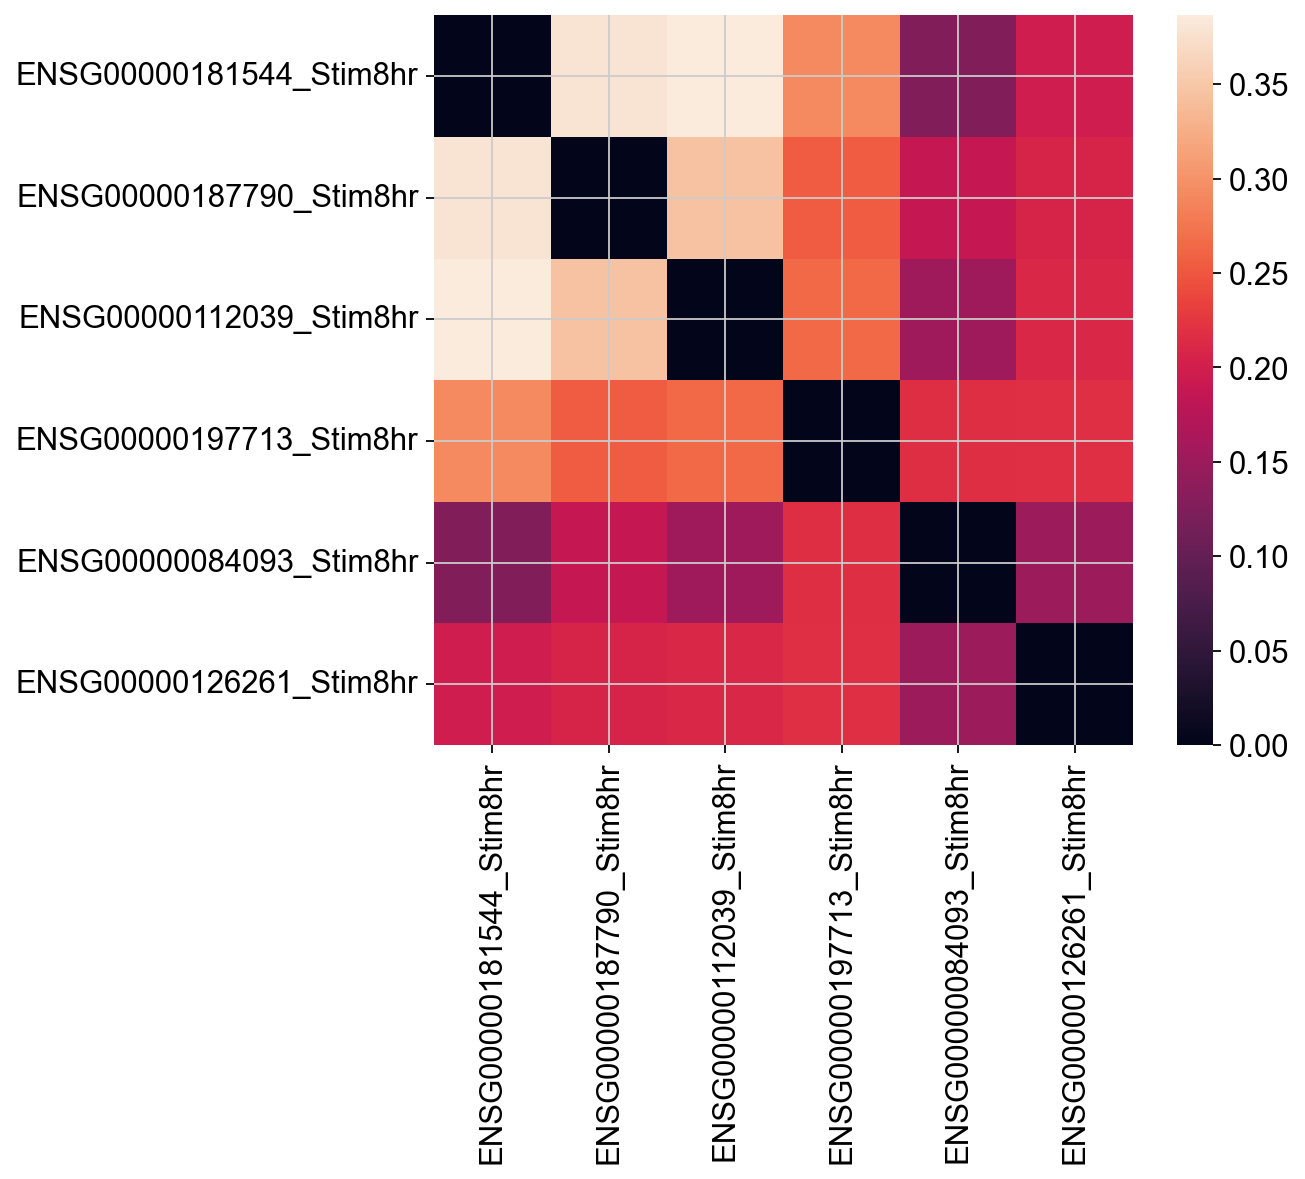

In [634]:
fig, ax = plt.subplots(figsize=(7,6))
test = pd.DataFrame(adata[ind,:].layers['zscore'].copy(),
                    index=adata[ind,:].obs.index,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())